In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings("ignore")
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,5)
import dask.dataframe as dd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.stats import chi2_contingency, randint
from lazypredict.Supervised import LazyRegressor
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import ccf

In [2]:
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/01-raw-data'
df = dd.read_csv(path+'/clustered_hdbscan_df.csv', usecols=['date','agency','agency_name','inquiry_name','brief_description','call_resolution','inquiry_with_description','cluster_label','embed_0','embed_1'])

In [3]:
# Compute the dataframe to see its contents
data_df = df.compute()
data_df['date'] = pd.DatetimeIndex(data_df['date'])

In [4]:
data_df.columns

Index(['date', 'agency', 'agency_name', 'inquiry_name', 'brief_description',
       'call_resolution', 'inquiry_with_description', 'cluster_label',
       'embed_0', 'embed_1'],
      dtype='object')

In [5]:
clusters_df = pd.DataFrame(data_df.groupby(['cluster_label']).count()[['inquiry_name']]).sort_values(by = 'inquiry_name',ascending=False)
clusters_df

,inquiry_name
cluster_label,
-1,1320074
17,717143
25,675138
114,637271
144,575759
...,...
98,576
41,561
180,405


In [6]:
#outliers
clusters_df[:1]

,inquiry_name
cluster_label,
-1,1320074


In [7]:
clusters_df[1:7].index

Int64Index([17, 25, 114, 144, 150, 13], dtype='int64', name='cluster_label')

### Top 6 clusters according to count

In [8]:
all_clusters_data = data_df[data_df['cluster_label'].isin(clusters_df[1:7].index)]
all_clusters_data.cluster_label.unique()

array([114, 144,  25, 150,  13,  17], dtype=int64)

In [9]:
# create a date range from the minimum to maximum date in your data
date_range = pd.date_range(start=all_clusters_data['date'].min(), end=all_clusters_data['date'].max(), freq='D')

# create a DataFrame with the date range
dates_df = pd.DataFrame({'date': date_range})

# merge the two DataFrames using a left join to preserve all dates
daily_clusters_df = pd.merge(dates_df, all_clusters_data.groupby(['date']).size().reset_index(name='inquiries_per_day'), on='date', how='left')

# replace missing values with 0
daily_clusters_df['inquiries_per_day'] = daily_clusters_df['inquiries_per_day'].fillna(0)

In [10]:
top6clusters = {}
daily_top6clusters = {}
daily_clusters = {}
for i,label in enumerate(clusters_df[1:7].index):
    print('Top:',i+1)
    value = data_df[data_df['cluster_label']==label]
    key = f"_{i+1}_{label}"
    top6clusters[key] = value
    value = value.groupby(["date"]).size().reset_index(name="inquiries_per_day")
    daily_top6clusters[key] = pd.merge(dates_df, value, on='date', how='left').fillna(0)

Top: 1
Top: 2
Top: 3
Top: 4
Top: 5
Top: 6


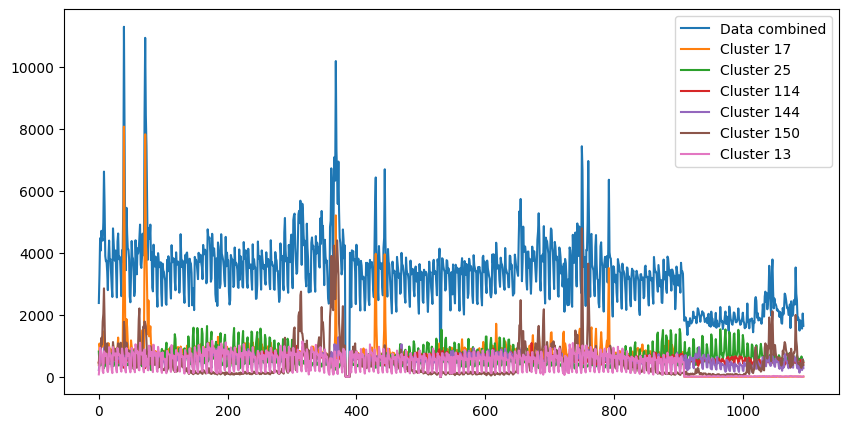

In [11]:
plt.plot(daily_clusters_df['inquiries_per_day'], label='Data combined')
plt.plot(daily_top6clusters['_1_17']['inquiries_per_day'], label='Cluster 17')
plt.plot(daily_top6clusters['_2_25']['inquiries_per_day'], label='Cluster 25')
plt.plot(daily_top6clusters['_3_114']['inquiries_per_day'], label='Cluster 114')
plt.plot(daily_top6clusters['_4_144']['inquiries_per_day'], label='Cluster 144')
plt.plot(daily_top6clusters['_5_150']['inquiries_per_day'], label='Cluster 150')
plt.plot(daily_top6clusters['_6_13']['inquiries_per_day'], label='Cluster 13')
plt.legend();

## Feature Engineering

In [12]:
import holidays
nyc_holidays = holidays.US(state='NY', years=[2017,2018,2019])

In [13]:
# function to create seasons for dataframe
def get_seasons(df):
    '''
    Function to create new features for seasons based on months
    Args: df = dataframe
    Returns: df = dataframe
    '''
    
    # create a season features
    df.loc[(df.index.month >=3) & (df.index.month <=5), 'season_spring'] = 1
    df.loc[(df.index.month >=6) & (df.index.month <=8), 'season_summer'] = 1
    df.loc[(df.index.month >=9) & (df.index.month <=11), 'season_fall'] = 1
    df.loc[((df.index.month >=1) & (df.index.month <=2)) | (df.index.month ==12), 'season_winter'] = 1

    return df

# function to create holidays for dataframe
def get_holidays(df):
    '''
    Function to create new features for holidays
    Args: df = dataframe
    Returns: df = dataframe
    '''

    # Create a DataFrame of holidays
    holidays_df = pd.DataFrame(nyc_holidays.items(), columns = ['date','holiday'])
    holidays_df['date'] = pd.to_datetime(holidays_df['date'])
    holidays_df = holidays_df.set_index(['date'])
    
    # Join the holidays DataFrame with the original DataFrame
    df = df.join(holidays_df, on='date')
    df = df.replace(to_replace=r'[^0]', value=1, regex=True).fillna(0)

    return df

# function to create weekdays for dataframe
def get_weekdays(df):
    '''
    Function to create new features for holidays
    Args: df = dataframe
    Returns: df = dataframe
    '''
    df['weekday'] = df.index.weekday
    ### one hot encode the feature weekday
    weekday_dummies = pd.get_dummies(df['weekday'], prefix='weekday')
    df = df.join(weekday_dummies, how='left')

    return df


Sunday - 6
Monday - 0
Tuesday - 1
Wednesday - 2
Thursday - 3
Friday - 4
Saturday - 5

In [14]:
# function to create weekdays for dataframe
def get_features(df,lags):
    '''
    Function to create new features
    Args: df = dataframe, lags = number of lags with high correlation
    Returns: df = dataframe
    '''
    df.reset_index(inplace = True)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace = True)

    df = get_seasons(df).fillna(0)
    df = get_holidays(df)
    df = get_weekdays(df)
    df[f'Mean_28days'] = df['inquiries_per_day'].rolling(28).mean().fillna(0)
    if (lags!=0):
        df[f'Inq_lag_{lags}'] = df['inquiries_per_day'].shift(12).fillna(0)
    
    #the data has a weekly seasonality, it might make sense to consider the mean of the last 4 weeks (4*7=28 days) as a feature.
    return df



# Overall combined dataset of 6 top clusters

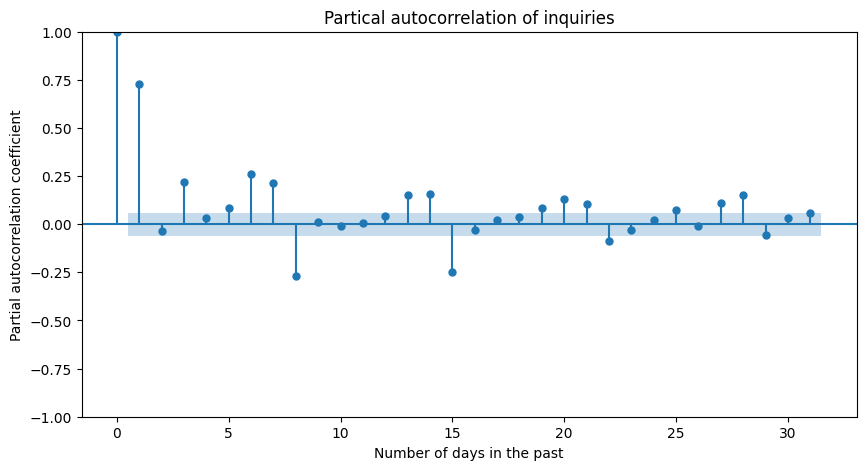

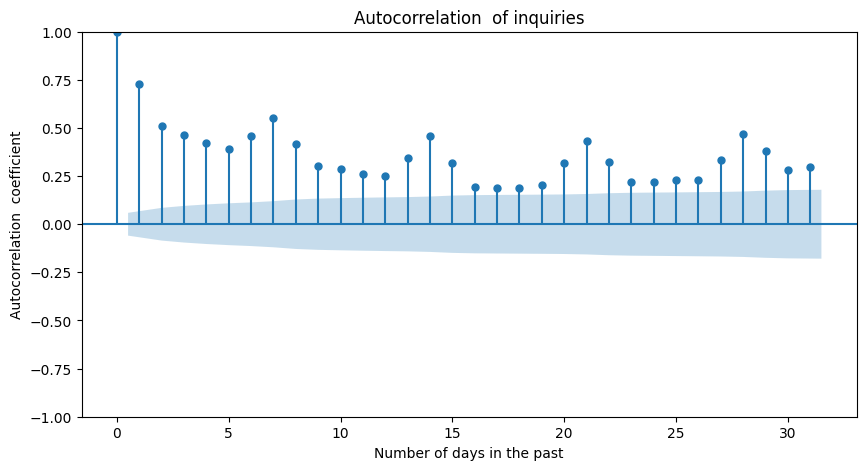

In [15]:
# plotting the partial autocorrelation for target
plot_pacf(daily_clusters_df['inquiries_per_day'], title='Partical autocorrelation of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Partial autocorrelation coefficient')
plt.show()

plot_acf(daily_clusters_df['inquiries_per_day'], title='Autocorrelation  of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Autocorrelation  coefficient')
plt.show()

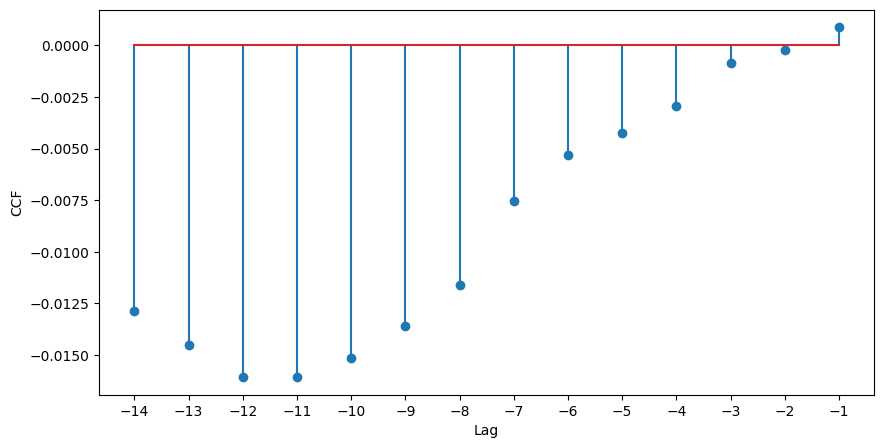

In [16]:
# Cross-correlation function (CCF)
data  = daily_clusters_df['inquiries_per_day']
lags = range(-14, 0)  # lags to consider
ccf_vals  = ccf(data, data, unbiased=False, fft=True)

# Extract CCF values for specified lags
lag_vals = np.array(lags)
ccf_vals = ccf_vals[lag_vals + max(lags)]

# Create pandas dataframe to store results
result_df = pd.DataFrame({'lag': lag_vals, 'ccf': ccf_vals})

# Print results
#print(result_df)

# plot CCF
plt.stem(lag_vals, ccf_vals)
plt.xticks(lag_vals)
plt.xlabel('Lag')
plt.ylabel('CCF')
plt.show()

In [17]:
daily_clusters_df = get_features(daily_clusters_df,12) # sane as lag=1
final_df  = daily_clusters_df.drop(columns=['weekday', 'index']).fillna(0)
final_df.columns

Index(['inquiries_per_day', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'holiday', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'Mean_28days',
       'Inq_lag_12'],
      dtype='object')

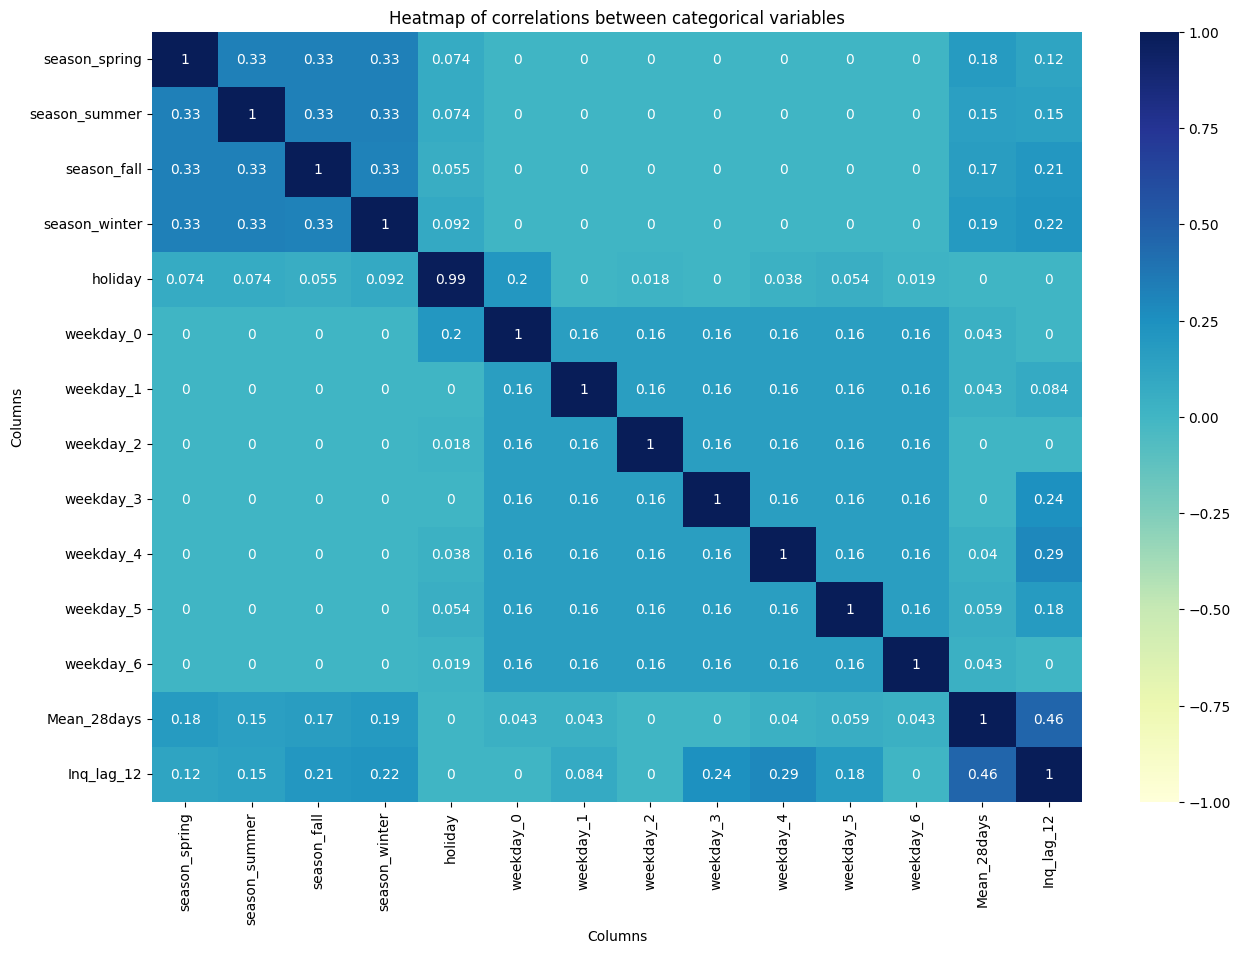

In [18]:
# drop any non-categorical variables
Daily_data_corr_cat = daily_clusters_df.drop(columns=['index','weekday', 'inquiries_per_day'], axis=1)


# this code snippet was taken from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


# create correlation matrix with cramer's V coefficients
corr_matrix = pd.DataFrame(data = None, index=np.arange(len(Daily_data_corr_cat.columns)), 
                            columns=Daily_data_corr_cat.columns)

for col in Daily_data_corr_cat.columns:
    count = 0
    for val in Daily_data_corr_cat.columns:
        corr_cat = cramers_v(Daily_data_corr_cat[col], Daily_data_corr_cat[val])
        corr_matrix[col][count] = corr_cat
        count += 1
    corr_matrix = corr_matrix.astype('float')


# add an index to the dataframe
corr_matrix['columns'] = Daily_data_corr_cat.columns
corr_matrix.set_index('columns', inplace=True)

# plot a heatmap for correlations between categorical variables
plt.figure(figsize=[15,10])
sns.heatmap(corr_matrix, annot=True,
          vmin=-1, vmax=1, center=0,
          fmt='.2g', cmap='YlGnBu')
plt.title('Heatmap of correlations between categorical variables')
plt.xlabel('Columns')
plt.ylabel('Columns');

### Modeling with Lazy Predict

In [19]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

# assigning X and y
y = final_df['inquiries_per_day']
X = final_df.drop(columns=['inquiries_per_day'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the LazyRegressor object and fit the data
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the results DataFrame
print(models)

100%|██████████| 42/42 [00:56<00:00,  1.34s/it]

                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
HistGradientBoostingRegressor                0.34       0.38    921.59   
PoissonRegressor                             0.32       0.36    938.21   
SGDRegressor                                 0.31       0.35    943.12   
KNeighborsRegressor                          0.31       0.35    944.09   
Lars                                         0.31       0.35    946.28   
Ridge                                        0.31       0.35    946.34   
Lasso                                        0.31       0.35    946.56   
RidgeCV                                      0.30       0.35    946.89   
BayesianRidge                                0.30       0.35    948.18   
GradientBoostingRegressor                    0.30       0.35    949.49   
LassoLarsIC                                  0.30       0.35    949.52   
LGBMRegressor                         

### Hyperparameter Tuning with cross validation

Grid search on combined dataset

In [20]:
from sklearn.model_selection import TimeSeriesSplit

# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)
# Initialize models
grid_search_model = RandomForestRegressor(random_state=0)

# Set up the grid to pick hyperparameters from:
param_grid = {"n_estimators": [100, 500, 1000],
              "max_depth": [None],
              "min_samples_split": [2,5,7,10],
              "min_samples_leaf": [1,2,3],
              "bootstrap": [True]}

# Create the randomized search object
grid_search = GridSearchCV(grid_search_model, param_grid=param_grid , cv=tscv, 
                                   scoring="neg_mean_squared_error")

# Fit the model to the data
y = final_df['inquiries_per_day']
X = final_df.drop(columns=['inquiries_per_day'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = False, random_state = 0)


# Fit the randomized search on the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_grid_all = grid_search.best_params_
print(best_params_grid_all)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}


Modeling with best parameters

In [21]:
# use the best hyperparameters to create the final Random Forest Regressor model
best_rfr_all = RandomForestRegressor(n_estimators=best_params_grid_all['n_estimators'],
                                  max_depth=best_params_grid_all['max_depth'],
                                  min_samples_split=best_params_grid_all['min_samples_split'],
                                  min_samples_leaf=best_params_grid_all['min_samples_leaf'],
                                  bootstrap=True,
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
best_rfr_all.fit(X_train, y_train)

# use the final Random Forest Regressor model to make predictions on the test set
train_pred = best_rfr_all.predict(X_train).astype(int)

# calculate the mean squared error of the predictions
train_mae = mean_absolute_error(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
print("Train MAE: ", train_mae)
print('Train RMSE:', train_rmse)

# use the final Random Forest Regressor model to make predictions on the test set
test_pred_allTopClusters = best_rfr_all.predict(X_test).astype(int)

# calculate the mean squared error of the predictions
test_mae = mean_absolute_error(y_test, test_pred_allTopClusters)
# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse_all = mean_squared_error(y_test, test_pred_allTopClusters)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred_allTopClusters))
print("Test MAE: ", test_mae)
print('Test RMSE:', test_rmse)


# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance = test_pred_allTopClusters.var()
bias = mse_all - variance
print('Model: Random Forest Regressor')
print(f'Variance: {variance}')
print(f'Bias: {bias}')

Train MAE:  334.7751141552511
Train RMSE: 640.1509141775667
Test MAE:  1127.2191780821918
Test RMSE: 1253.99064360408
Model: Random Forest Regressor
Variance: 129501.59783991158
Bias: 1442990.9364066636


In [22]:
train_rf = pd.DataFrame()
train_rf['train'] = y_train
train_rf['train_pred'] = train_pred
predictions_rf = pd.DataFrame()
predictions_rf['test'] = y_test
predictions_rf['test_pred'] = test_pred_allTopClusters
train_rf['residuals'] = train_rf['train'] - train_rf['train_pred']
predictions_rf['residuals'] = predictions_rf['test'] - predictions_rf['test_pred']

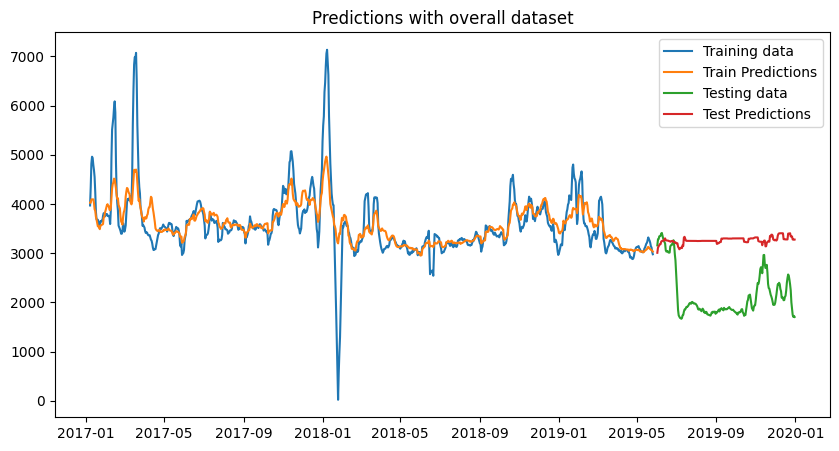

In [23]:
#lag=1 new
plt.title('Predictions with overall dataset')
plt.plot(train_rf[['train']].sort_index().rolling(7).mean(), label='Training data')
plt.plot(train_rf[['train_pred']].sort_index().rolling(7).mean(), label='Train Predictions')
plt.plot(predictions_rf[['test','test_pred']].sort_index().rolling(7).mean(), label=['Testing data','Test Predictions'])
#plt.plot(predictions_rf['residuals'].rolling(7).mean(), label = 'residual')
plt.legend();

In [24]:
new_plot=train_rf[train_rf.index.year == 2019]

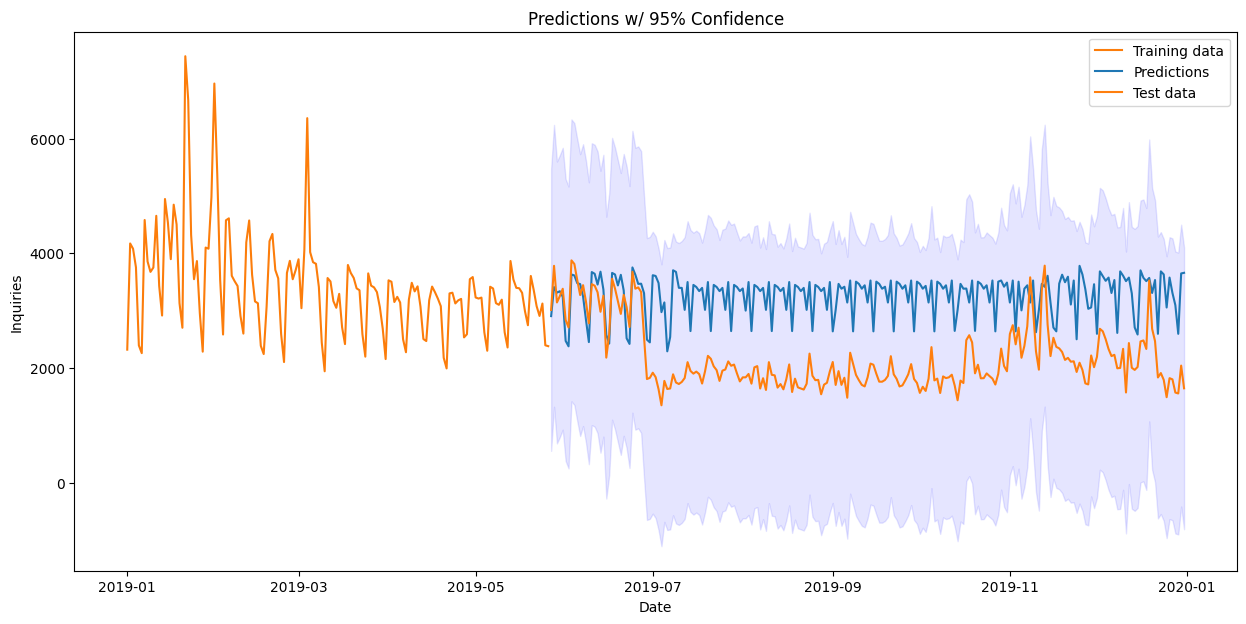

In [25]:
RMSFE = np.sqrt(sum([x**2 for x in predictions_rf['residuals'] ]) / len(predictions_rf['residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(new_plot.index, new_plot['train'], color='#fc7d0b', label='Training data')
ax.plot(predictions_rf.index, predictions_rf['test_pred'], label='Predictions')
ax.plot(predictions_rf.index, predictions_rf['test'], label='Test data')
ax.fill_between(predictions_rf.index, (predictions_rf['test']-band_size), (predictions_rf['test']+band_size), color='b', alpha=.1)
ax.set_title("Predictions w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.legend()
plt.show()

Feature Importance

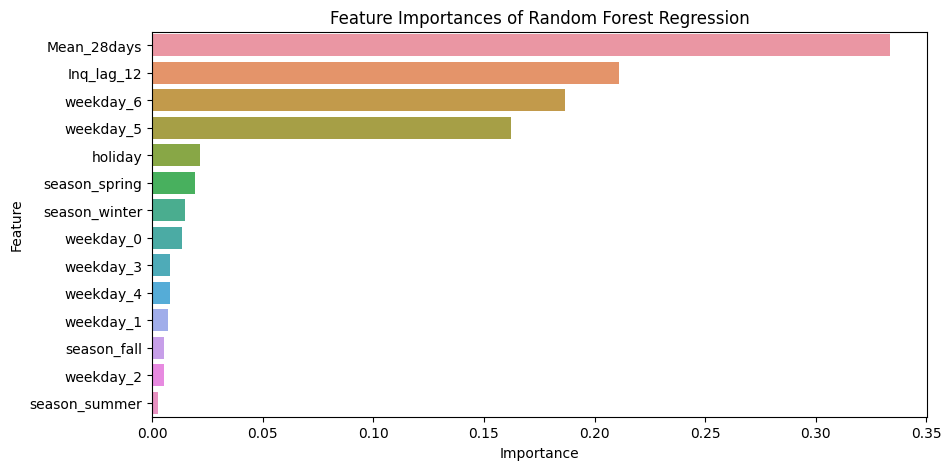

In [26]:
# Access the feature importances
importances = best_rfr_all.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()


In [27]:
predictions_rf

,test,test_pred,residuals
date,,,
2019-05-27,3011.00,2904,107.00
2019-05-28,3781.00,3410,371.00
2019-05-29,3142.00,3313,-171.00
2019-05-30,3252.00,3338,-86.00
2019-05-31,3381.00,3241,140.00
...,...,...,...
2019-12-27,1801.00,3307,-1506.00
2019-12-28,1571.00,3095,-1524.00
2019-12-29,1555.00,2595,-1040.00


# 1st Top cluster --> cluster_label = 17

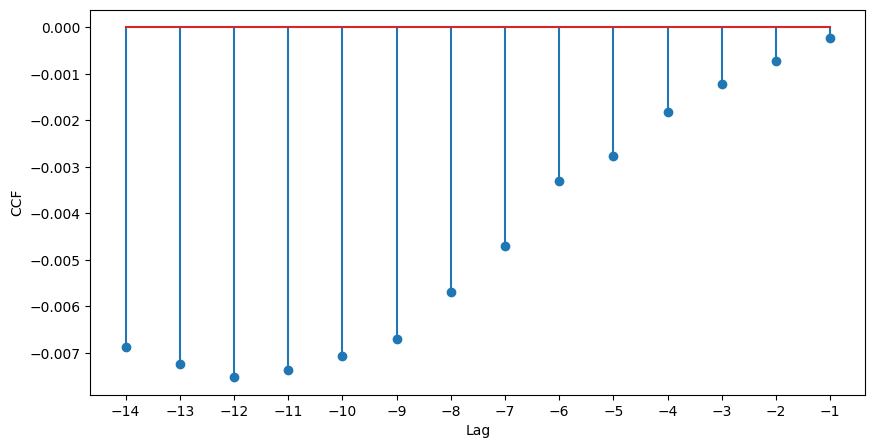

In [28]:
# Cross-correlation function (CCF)
data  = daily_top6clusters['_1_17']['inquiries_per_day']
lags = range(-14, 0)  # lags to consider
ccf_vals  = ccf(data, data, unbiased=False, fft=True)

# Extract CCF values for specified lags
lag_vals = np.array(lags)
ccf_vals = ccf_vals[lag_vals + max(lags)]

# Create pandas dataframe to store results
result_df = pd.DataFrame({'lag': lag_vals, 'ccf': ccf_vals})

# Print results
#print(result_df)

# plot CCF
plt.stem(lag_vals, ccf_vals)
plt.xticks(lag_vals)
plt.xlabel('Lag')
plt.ylabel('CCF')
plt.show()

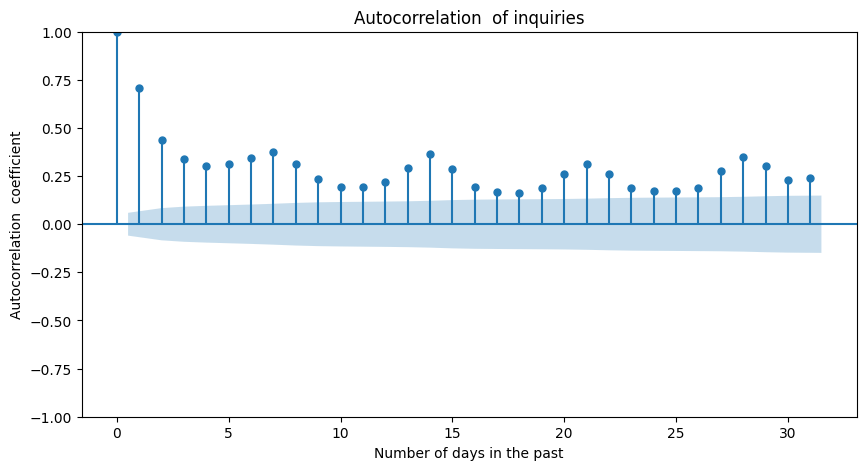

In [29]:
plot_acf(daily_top6clusters['_1_17']['inquiries_per_day'], title='Autocorrelation  of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Autocorrelation  coefficient')
plt.show()

In [30]:
daily_clusters['_1_17'] = get_features(daily_top6clusters['_1_17'],12)
daily_clusters['_1_17']['Inq_lag_1'] = daily_clusters['_1_17']['inquiries_per_day'].shift(1).fillna(0)
final_1_df  = daily_clusters['_1_17'].drop(columns=['weekday', 'index']).fillna(0)
final_1_df.columns

Index(['inquiries_per_day', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'holiday', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'Mean_28days',
       'Inq_lag_12', 'Inq_lag_1'],
      dtype='object')

### Modeling with Lazy Predict

In [31]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

# assigning X and y
y = final_1_df['inquiries_per_day']
X = final_1_df.drop(columns=['inquiries_per_day'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the LazyRegressor object and fit the data
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the results DataFrame
print(models)

100%|██████████| 42/42 [00:50<00:00,  1.21s/it]

                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
RANSACRegressor                              0.59       0.62   430.61   
HuberRegressor                               0.53       0.56   459.71   
PassiveAggressiveRegressor                   0.52       0.55   467.15   
SGDRegressor                                 0.51       0.55   469.37   
Ridge                                        0.51       0.55   469.39   
Lars                                         0.51       0.55   469.50   
Lasso                                        0.51       0.55   469.68   
RidgeCV                                      0.51       0.54   470.92   
BayesianRidge                                0.51       0.54   471.03   
LassoLarsIC                                  0.51       0.54   471.27   
TransformedTargetRegressor                   0.50       0.54   472.91   
LinearRegression                             0.50  

### Hyperparameter Tuning with cross validation

Grid search on combined dataset

In [32]:
# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)
# Initialize models
grid_search_model = RandomForestRegressor(random_state=0)

# Set up the grid to pick hyperparameters from:
param_grid = {"n_estimators": [100, 500, 1000],
              "max_depth": [None],
              "min_samples_split": [2,3,5,7,8,10],
              "min_samples_leaf": [1,2,3],
              "bootstrap": [True]}

# Create the randomized search object
grid_search = GridSearchCV(grid_search_model, param_grid=param_grid , cv=tscv, 
                                   scoring="neg_mean_squared_error")

# Fit the model to the data
y = final_1_df['inquiries_per_day']
X = final_1_df.drop(columns=['inquiries_per_day'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = False, random_state = 0)


# Fit the randomized search on the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_grid_1 = grid_search.best_params_
print(best_params_grid_1)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}


Modeling with best parameters

In [33]:
# use the best hyperparameters to create the final Random Forest Regressor model
best_rfr_cluster1 = RandomForestRegressor(n_estimators=best_params_grid_1['n_estimators'],
                                  max_depth=best_params_grid_1['max_depth'],
                                  min_samples_split=best_params_grid_1['min_samples_split'],
                                  min_samples_leaf=best_params_grid_1['min_samples_leaf'],
                                  bootstrap=True,
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
best_rfr_cluster1.fit(X_train, y_train)

# use the final Random Forest Regressor model to make predictions on the train set
train_pred_1 = best_rfr_cluster1.predict(X_train).astype(int)

# calculate the mean squared error of the predictions
train_mae_1 = mean_absolute_error(y_train, train_pred_1)
train_rmse_1 = np.sqrt(mean_squared_error(y_train, train_pred_1))
print("Train MAE of Cluster #1: ", train_mae_1)
print('Train RMSE of Cluster #1:', train_rmse_1)

# use the final Random Forest Regressor model to make predictions on the test set
test_pred_1 = best_rfr_cluster1.predict(X_test).astype(int)

# calculate the mean squared error of the predictions
test_mae_1 = mean_absolute_error(y_test, test_pred_1)
# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse_1 = mean_squared_error(y_test, test_pred_1)
test_rmse_1 = np.sqrt(mean_squared_error(y_test, test_pred_1))
print("Test MAE of Cluster #1: ", test_mae_1)
print('Test RMSE of Cluster #1:', test_rmse_1)


# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance_1 = test_pred_1.var()
bias_1 = mse_1 - variance_1
print('Model: Random Forest Regressor')
print(f'Variance of Cluster #1: {variance_1}')
print(f'Bias of Cluster #1: {bias_1}')

Train MAE of Cluster #1:  109.72602739726027
Train RMSE of Cluster #1: 334.38968804423325
Test MAE of Cluster #1:  265.4063926940639
Test RMSE of Cluster #1: 279.52105155934174
Model: Random Forest Regressor
Variance of Cluster #1: 29848.855736952934
Bias of Cluster #1: 48283.16252788725


In [34]:
train_rf_1 = pd.DataFrame()
train_rf_1['actual_data'] = y_train
train_rf_1['predictions'] = train_pred_1
test_rf_1 = pd.DataFrame()
test_rf_1['actual_data'] = y_test
test_rf_1['predictions'] = test_pred_1
train_rf_1['residuals'] = train_rf_1['actual_data'] - train_rf_1['predictions']
test_rf_1['residuals'] = test_rf_1['actual_data'] - test_rf_1['predictions']

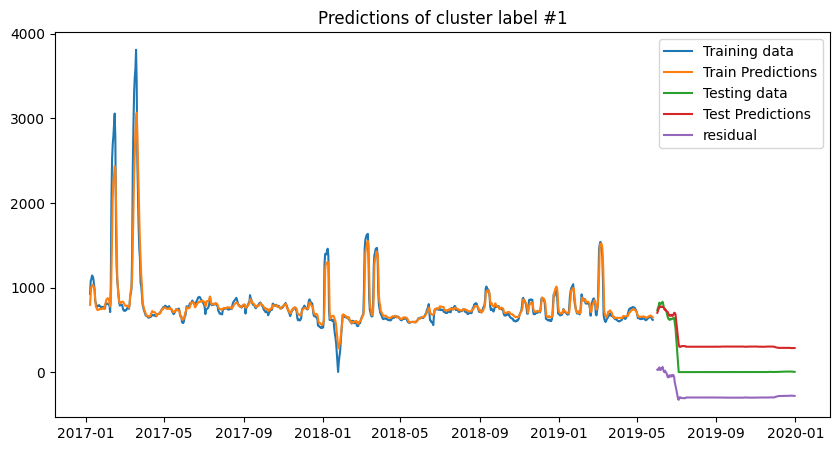

In [35]:
# lag = 12 & 1 & mean of 28 days
plt.title('Predictions of cluster label #1')
plt.plot(train_rf_1[['actual_data']].sort_index().rolling(7).mean(), label='Training data')
plt.plot(train_rf_1[['predictions']].sort_index().rolling(7).mean(), label='Train Predictions')
plt.plot(test_rf_1[['actual_data','predictions']].sort_index().rolling(7).mean(), label=['Testing data','Test Predictions'])
plt.plot(test_rf_1['residuals'].rolling(7).mean(), label = 'residual')
plt.legend();

In [36]:
new_plot=train_rf_1[train_rf_1.index.year == 2019]

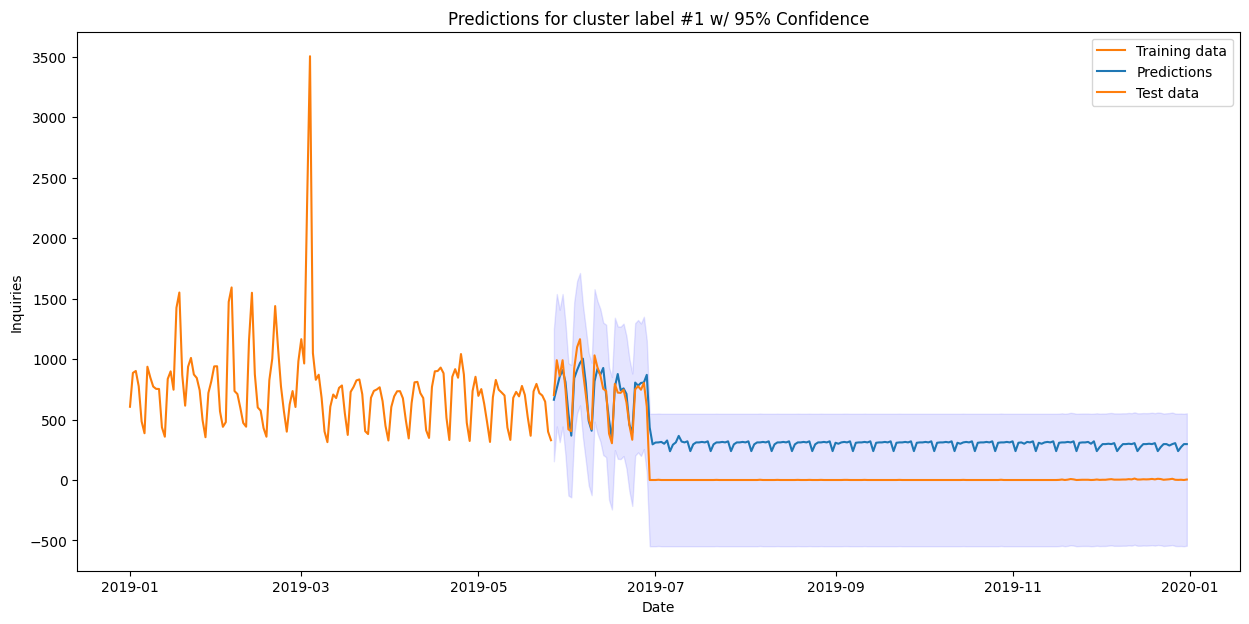

In [37]:
RMSFE = np.sqrt(sum([x**2 for x in test_rf_1['residuals'] ]) / len(test_rf_1['residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(new_plot.index, new_plot['actual_data'], color='#fc7d0b', label='Training data')
ax.plot(test_rf_1.index, test_rf_1['predictions'], label='Predictions')
ax.plot(test_rf_1.index, test_rf_1['actual_data'], label='Test data')
ax.fill_between(test_rf_1.index, (test_rf_1['actual_data']-band_size), (test_rf_1['actual_data']+band_size), color='b', alpha=.1)
ax.set_title("Predictions for cluster label #1 w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.legend()
plt.show()

Feature Importance

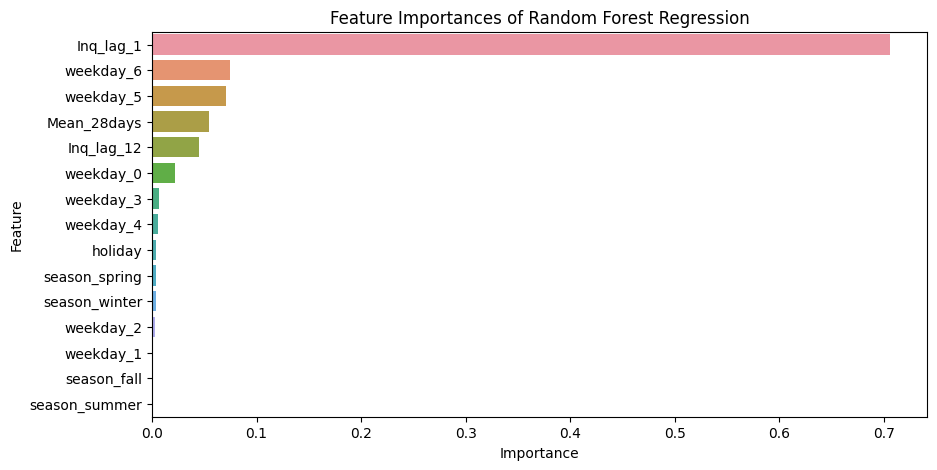

In [38]:
# Access the feature importances
importances = best_rfr_cluster1.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()


# 2nd Top cluster --> cluster_label = 25

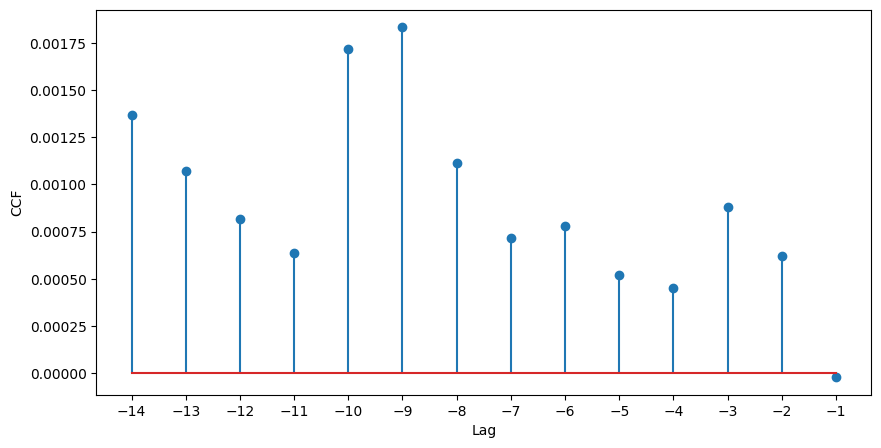

In [39]:
# Cross-correlation function (CCF)
data  = daily_top6clusters['_2_25']['inquiries_per_day']
lags = range(-14,0)  # lags to consider
ccf_vals  = ccf(data, data, unbiased=False, fft=True)

# Extract CCF values for specified lags
lag_vals = np.array(lags)
ccf_vals = ccf_vals[lag_vals + max(lags)]

# Create pandas dataframe to store results
result_df = pd.DataFrame({'lag': lag_vals, 'ccf': ccf_vals})

# Print results
#print(result_df)

# plot CCF
plt.stem(lag_vals, ccf_vals)
plt.xticks(lag_vals)
plt.xlabel('Lag')
plt.ylabel('CCF')
plt.show()

In [40]:
daily_clusters['_2_25'] = get_features(daily_top6clusters['_2_25'],9)
final_2_df  = daily_clusters['_2_25'].drop(columns=['weekday', 'index']).fillna(0)
final_2_df.columns

Index(['inquiries_per_day', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'holiday', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'Mean_28days',
       'Inq_lag_9'],
      dtype='object')

### Modeling with Lazy Predict

In [41]:
# assigning X and y
y = final_2_df['inquiries_per_day']
X = final_2_df.drop(columns=['inquiries_per_day'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the LazyRegressor object and fit the data
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the results DataFrame
print(models)

100%|██████████| 42/42 [00:21<00:00,  1.94it/s]

                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
GradientBoostingRegressor                    0.77       0.78   123.69   
RandomForestRegressor                        0.73       0.74   134.40   
KNeighborsRegressor                          0.72       0.74   134.43   
HistGradientBoostingRegressor                0.72       0.74   134.64   
BaggingRegressor                             0.72       0.73   136.78   
LGBMRegressor                                0.71       0.73   137.51   
ExtraTreesRegressor                          0.71       0.73   137.69   
PoissonRegressor                             0.70       0.72   141.20   
XGBRegressor                                 0.68       0.70   144.79   
SGDRegressor                                 0.62       0.64   158.66   
OrthogonalMatchingPursuitCV                  0.62       0.64   158.85   
Lasso                                        0.61  

### Hyperparameter Tuning with cross validation

Grid search on combined dataset

In [42]:
# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)
# Initialize models
grid_search_model = RandomForestRegressor(random_state=0)

# Set up the grid to pick hyperparameters from:
param_grid = {"n_estimators": [100, 500, 1000],
              "max_depth": [None],
              "min_samples_split": [2,3,5,7,8,10],
              "min_samples_leaf": [1,2,3],
              "bootstrap": [True]}

# Create the randomized search object
grid_search = GridSearchCV(grid_search_model, param_grid=param_grid , cv=tscv, 
                                   scoring="neg_mean_squared_error")

# Fit the model to the data
y = final_2_df['inquiries_per_day']
X = final_2_df.drop(columns=['inquiries_per_day'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = False, random_state = 0)


# Fit the randomized search on the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_grid_2 = grid_search.best_params_
print(best_params_grid_2)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


Modeling with best parameters

In [43]:
# use the best hyperparameters to create the final Random Forest Regressor model
best_rfr_cluster2 = RandomForestRegressor(n_estimators=best_params_grid_2['n_estimators'],
                                  max_depth=best_params_grid_2['max_depth'],
                                  min_samples_split=best_params_grid_2['min_samples_split'],
                                  min_samples_leaf=best_params_grid_2['min_samples_leaf'],
                                  bootstrap=True,
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
best_rfr_cluster2.fit(X_train, y_train)

# use the final Random Forest Regressor model to make predictions on the train set
train_pred_2 = best_rfr_cluster2.predict(X_train).astype(int)

# calculate the mean squared error of the predictions
train_mae_2 = mean_absolute_error(y_train, train_pred_2)
train_rmse_2 = np.sqrt(mean_squared_error(y_train, train_pred_2))
print("Train MAE of Cluster #2: ", train_mae_2)
print('Train RMSE of Cluster #2:', train_rmse_2)

# use the final Random Forest Regressor model to make predictions on the test set
test_pred_2 = best_rfr_cluster2.predict(X_test).astype(int)

# calculate the mean squared error of the predictions
test_mae_2 = mean_absolute_error(y_test, test_pred_2)
# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse_2 = mean_squared_error(y_test, test_pred_2)
test_rmse_2 = np.sqrt(mean_squared_error(y_test, test_pred_2))
print("Test MAE of Cluster #2: ", test_mae_2)
print('Test RMSE of Cluster #2:', test_rmse_2)


# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance_2 = test_pred_2.var()
bias_2 = mse_2 - variance_2
print('Model: Random Forest Regressor')
print(f'Variance of Cluster #2: {variance_2}')
print(f'Bias of Cluster #2: {bias_2}')

Train MAE of Cluster #2:  47.981735159817354
Train RMSE of Cluster #2: 70.64864183837723
Test MAE of Cluster #2:  126.34246575342466
Test RMSE of Cluster #2: 167.54579555245763
Model: Random Forest Regressor
Variance of Cluster #2: 102958.72913408812
Bias of Cluster #2: -74887.1355267822


In [44]:
train_rf_2 = pd.DataFrame()
train_rf_2['actual_data'] = y_train
train_rf_2['predictions'] = train_pred_2
test_rf_2 = pd.DataFrame()
test_rf_2['actual_data'] = y_test
test_rf_2['predictions'] = test_pred_2
train_rf_2['residuals'] = train_rf_2['actual_data'] - train_rf_2['predictions']
test_rf_2['residuals'] = test_rf_2['actual_data'] - test_rf_2['predictions']

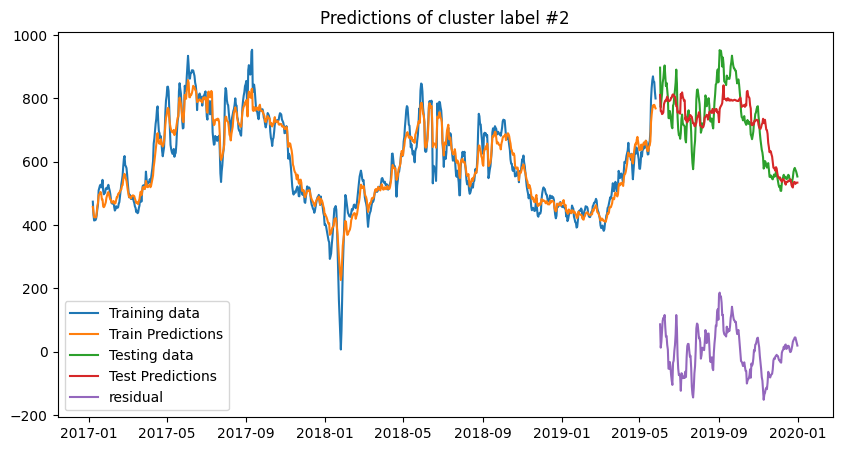

In [45]:
#lag=9
plt.title('Predictions of cluster label #2')
plt.plot(train_rf_2[['actual_data']].sort_index().rolling(7).mean(), label='Training data')
plt.plot(train_rf_2[['predictions']].sort_index().rolling(7).mean(), label='Train Predictions')
plt.plot(test_rf_2[['actual_data','predictions']].sort_index().rolling(7).mean(), label=['Testing data','Test Predictions'])
plt.plot(test_rf_2['residuals'].rolling(7).mean(), label = 'residual')
plt.legend();

In [46]:
new_plot=train_rf_2[train_rf_2.index.year == 2019]

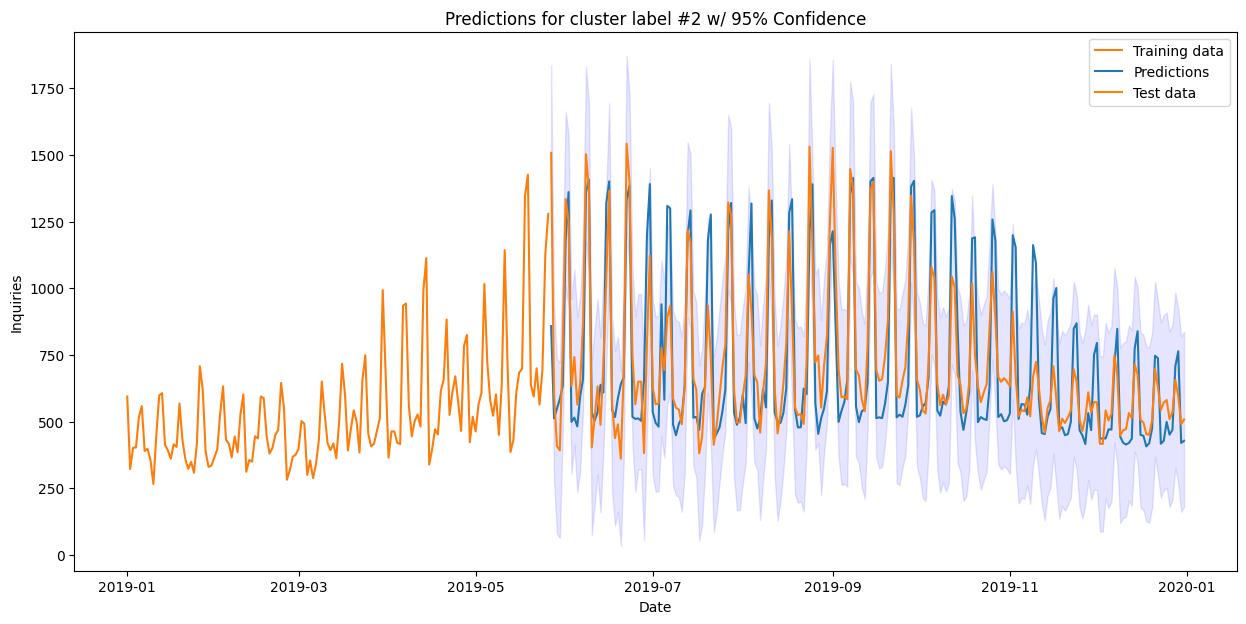

In [47]:
RMSFE = np.sqrt(sum([x**2 for x in test_rf_2['residuals'] ]) / len(test_rf_2['residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(new_plot.index, new_plot['actual_data'], color='#fc7d0b', label='Training data')
ax.plot(test_rf_2.index, test_rf_2['predictions'], label='Predictions')
ax.plot(test_rf_2.index, test_rf_2['actual_data'], label='Test data')
ax.fill_between(test_rf_2.index, (test_rf_2['actual_data']-band_size), (test_rf_2['actual_data']+band_size), color='b', alpha=.1)
ax.set_title("Predictions for cluster label #2 w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.legend()
plt.show()

Feature Importance

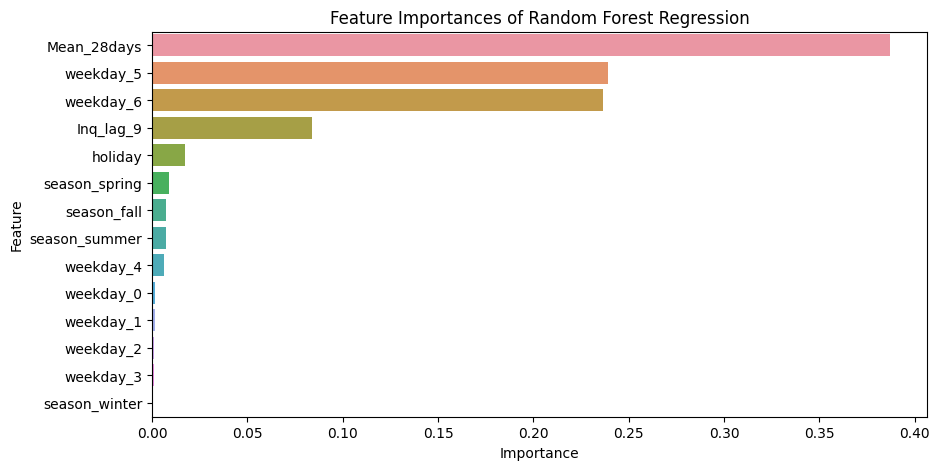

In [48]:
# Access the feature importances
importances = best_rfr_cluster2.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()


# 3rd Top cluster --> cluster_label = 114

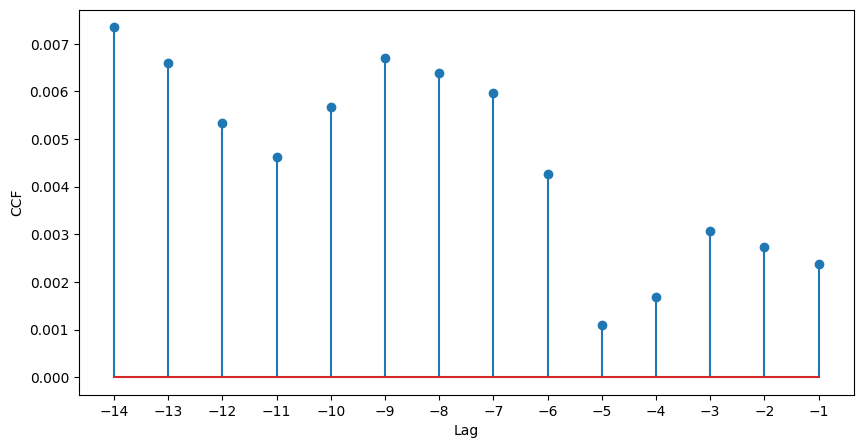

In [49]:
# Cross-correlation function (CCF)
data  = daily_top6clusters['_3_114']['inquiries_per_day']
lags = range(-14,0)  # lags to consider
ccf_vals  = ccf(data, data, unbiased=False, fft=True)

# Extract CCF values for specified lags
lag_vals = np.array(lags)
ccf_vals = ccf_vals[lag_vals + max(lags)]

# Create pandas dataframe to store results
result_df = pd.DataFrame({'lag': lag_vals, 'ccf': ccf_vals})

# Print results
#print(result_df)

# plot CCF
plt.stem(lag_vals, ccf_vals)
plt.xticks(lag_vals)
plt.xlabel('Lag')
plt.ylabel('CCF')
plt.show()

In [50]:
daily_clusters['_3_114'] = get_features(daily_top6clusters['_3_114'],14)
final_3_df  = daily_clusters['_3_114'].drop(columns=['weekday', 'index']).fillna(0)
final_3_df.columns

Index(['inquiries_per_day', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'holiday', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'Mean_28days',
       'Inq_lag_14'],
      dtype='object')

### Modeling with Lazy Predict

In [51]:
# assigning X and y
y = final_3_df['inquiries_per_day']
X = final_3_df.drop(columns=['inquiries_per_day'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the LazyRegressor object and fit the data
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the results DataFrame
print(models)

100%|██████████| 42/42 [00:17<00:00,  2.36it/s]

                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
RandomForestRegressor                        0.47       0.50     80.92   
HistGradientBoostingRegressor                0.46       0.49     81.68   
LGBMRegressor                                0.44       0.48     82.85   
GradientBoostingRegressor                    0.43       0.47     83.53   
KNeighborsRegressor                          0.39       0.43     86.84   
BaggingRegressor                             0.36       0.40     89.08   
ExtraTreesRegressor                          0.35       0.39     89.52   
PoissonRegressor                             0.35       0.39     89.72   
XGBRegressor                                 0.31       0.36     92.10   
Lasso                                        0.31       0.35     92.16   
LassoCV                                      0.31       0.35     92.22   
ElasticNetCV                          

### Hyperparameter Tuning with cross validation

Grid search on combined dataset

In [52]:
# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)
# Initialize models
grid_search_model = RandomForestRegressor(random_state=0)

# Set up the grid to pick hyperparameters from:
param_grid = {"n_estimators": [100, 500, 1000],
              "max_depth": [None],
              "min_samples_split": [2,3,5,7,8,10],
              "min_samples_leaf": [1,2,3],
              "bootstrap": [True]}

# Create the randomized search object
grid_search = GridSearchCV(grid_search_model, param_grid=param_grid , cv=tscv, 
                                   scoring="neg_mean_squared_error")

# Fit the model to the data
y = final_3_df['inquiries_per_day']
X = final_3_df.drop(columns=['inquiries_per_day'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = False, random_state = 0)


# Fit the randomized search on the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_grid_3 = grid_search.best_params_
print(best_params_grid_3)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1000}


Modeling with best parameters

In [53]:
# use the best hyperparameters to create the final Random Forest Regressor model
best_rfr_cluster3 = RandomForestRegressor(n_estimators=best_params_grid_3['n_estimators'],
                                  max_depth=best_params_grid_3['max_depth'],
                                  min_samples_split=best_params_grid_3['min_samples_split'],
                                  min_samples_leaf=best_params_grid_3['min_samples_leaf'],
                                  bootstrap=True,
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
best_rfr_cluster3.fit(X_train, y_train)

# use the final Random Forest Regressor model to make predictions on the train set
train_pred_3 = best_rfr_cluster3.predict(X_train).astype(int)

# calculate the mean squared error of the predictions
train_mae_3 = mean_absolute_error(y_train, train_pred_3)
train_rmse_3 = np.sqrt(mean_squared_error(y_train, train_pred_3))
print("Train MAE of Cluster #3: ", train_mae_3)
print('Train RMSE of Cluster #3:', train_rmse_3)

# use the final Random Forest Regressor model to make predictions on the test set
test_pred_3 = best_rfr_cluster3.predict(X_test).astype(int)

# calculate the mean squared error of the predictions
test_mae_3 = mean_absolute_error(y_test, test_pred_3)
# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse_3 = mean_squared_error(y_test, test_pred_3)
test_rmse_3 = np.sqrt(mean_squared_error(y_test, test_pred_3))
print("Test MAE of Cluster #3: ", test_mae_3)
print('Test RMSE of Cluster #3:', test_rmse_3)


# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance_3 = test_pred_3.var()
bias_3 = mse_3 - variance_3
print('Model: Random Forest Regressor')
print(f'Variance of Cluster #3: {variance_3}')
print(f'Bias of Cluster #3: {bias_3}')

Train MAE of Cluster #3:  41.42123287671233
Train RMSE of Cluster #3: 64.13161587899639
Test MAE of Cluster #3:  47.51598173515982
Test RMSE of Cluster #3: 62.364007299023804
Model: Random Forest Regressor
Variance of Cluster #3: 5411.58295281583
Bias of Cluster #3: -1522.313546423136


In [54]:
train_rf_3 = pd.DataFrame()
train_rf_3['actual_data'] = y_train
train_rf_3['predictions'] = train_pred_3
test_rf_3 = pd.DataFrame()
test_rf_3['actual_data'] = y_test
test_rf_3['predictions'] = test_pred_3
train_rf_3['residuals'] = train_rf_3['actual_data'] - train_rf_3['predictions']
test_rf_3['residuals'] = test_rf_3['actual_data'] - test_rf_3['predictions']

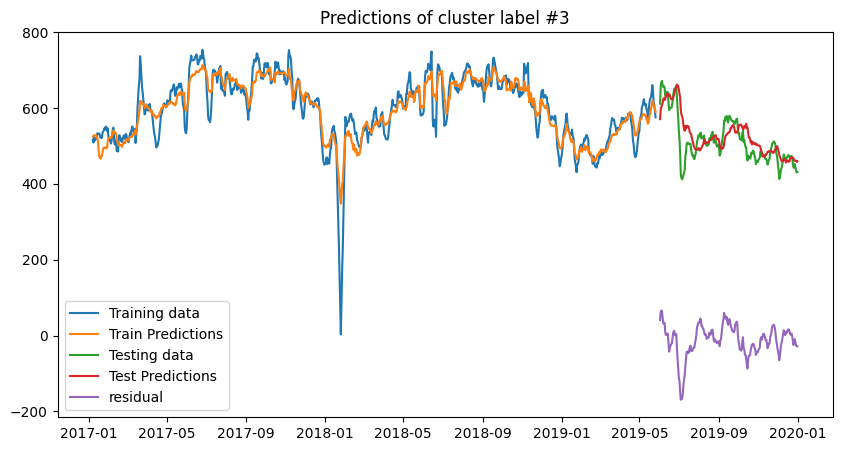

In [55]:
#lag=14
plt.title('Predictions of cluster label #3')
plt.plot(train_rf_3[['actual_data']].sort_index().rolling(7).mean(), label='Training data')
plt.plot(train_rf_3[['predictions']].sort_index().rolling(7).mean(), label='Train Predictions')
plt.plot(test_rf_3[['actual_data','predictions']].sort_index().rolling(7).mean(), label=['Testing data','Test Predictions'])
plt.plot(test_rf_3['residuals'].rolling(7).mean(), label = 'residual')
plt.legend();

In [56]:
new_plot=train_rf_3[train_rf_3.index.year == 2019]

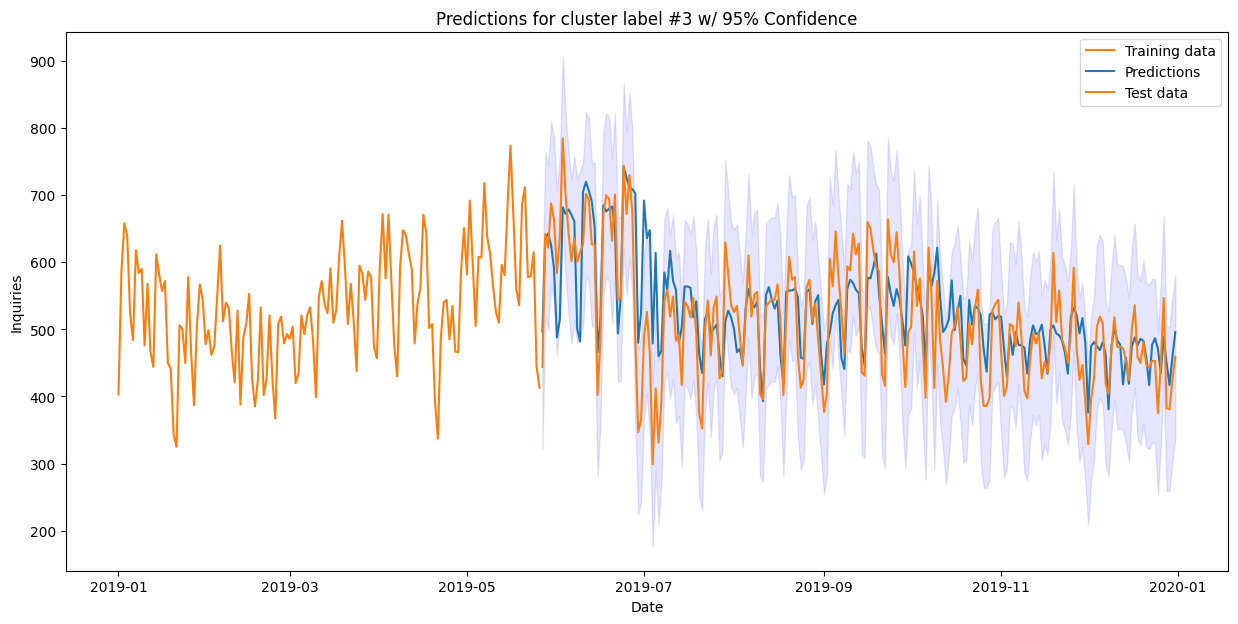

In [57]:
RMSFE = np.sqrt(sum([x**2 for x in test_rf_3['residuals'] ]) / len(test_rf_3['residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(new_plot.index, new_plot['actual_data'], color='#fc7d0b', label='Training data')
ax.plot(test_rf_3.index, test_rf_3['predictions'], label='Predictions')
ax.plot(test_rf_3.index, test_rf_3['actual_data'], label='Test data')
ax.fill_between(test_rf_3.index, (test_rf_3['actual_data']-band_size), (test_rf_3['actual_data']+band_size), color='b', alpha=.1)
ax.set_title("Predictions for cluster label #3 w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.legend()
plt.show()

Feature Importance

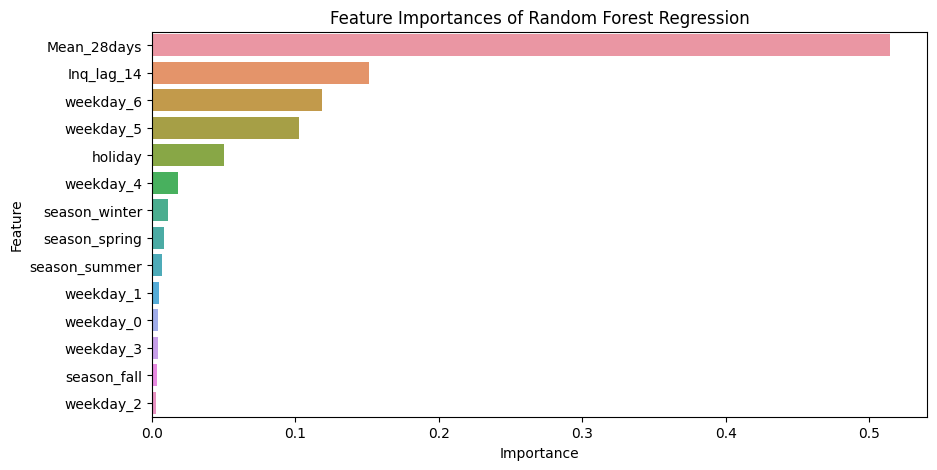

In [58]:
# Access the feature importances
importances = best_rfr_cluster3.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()


In [59]:
test_rf_3

,actual_data,predictions,residuals
date,,,
2019-05-27,444.00,497,-53.00
2019-05-28,642.00,636,6.00
2019-05-29,622.00,643,-21.00
2019-05-30,688.00,626,62.00
2019-05-31,664.00,591,73.00
...,...,...,...
2019-12-27,547.00,489,58.00
2019-12-28,382.00,450,-68.00
2019-12-29,381.00,417,-36.00


# 4th Top cluster --> cluster_label = 144

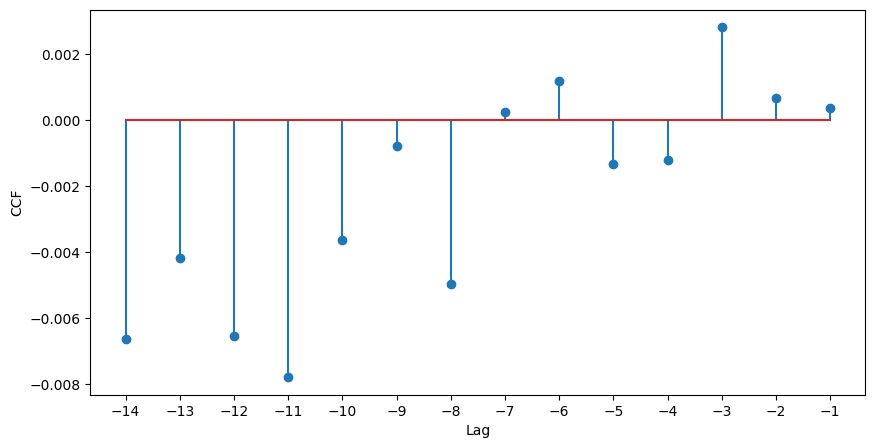

In [60]:
# Cross-correlation function (CCF)
data  = daily_top6clusters['_4_144']['inquiries_per_day']
lags = range(-14,0)  # lags to consider
ccf_vals  = ccf(data, data, unbiased=False, fft=True)

# Extract CCF values for specified lags
lag_vals = np.array(lags)
ccf_vals = ccf_vals[lag_vals + max(lags)]

# Create pandas dataframe to store results
result_df = pd.DataFrame({'lag': lag_vals, 'ccf': ccf_vals})

# Print results
#print(result_df)

# plot CCF
plt.stem(lag_vals, ccf_vals)
plt.xticks(lag_vals)
plt.xlabel('Lag')
plt.ylabel('CCF')
plt.show()

In [61]:
daily_clusters['_4_144'] = get_features(daily_top6clusters['_4_144'],11)
final_4_df  = daily_clusters['_4_144'].drop(columns=['weekday', 'index']).fillna(0)
final_4_df.columns

Index(['inquiries_per_day', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'holiday', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'Mean_28days',
       'Inq_lag_11'],
      dtype='object')

### Modeling with Lazy Predict

In [62]:
# assigning X and y
y = final_4_df['inquiries_per_day']
X = final_4_df.drop(columns=['inquiries_per_day'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the LazyRegressor object and fit the data
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the results DataFrame
print(models)

100%|██████████| 42/42 [00:23<00:00,  1.76it/s]

                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
GradientBoostingRegressor                    0.66       0.68   101.16   
KNeighborsRegressor                          0.64       0.66   103.73   
HistGradientBoostingRegressor                0.64       0.66   104.14   
RandomForestRegressor                        0.63       0.65   105.60   
XGBRegressor                                 0.62       0.64   107.03   
LGBMRegressor                                0.61       0.63   108.62   
BaggingRegressor                             0.60       0.63   109.46   
PoissonRegressor                             0.60       0.62   109.88   
SGDRegressor                                 0.59       0.62   110.86   
ElasticNetCV                                 0.59       0.62   110.98   
RidgeCV                                      0.59       0.62   110.99   
ExtraTreesRegressor                          0.59  

### Hyperparameter Tuning with cross validation

Grid search on combined dataset

In [63]:
# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)
# Initialize models
grid_search_model = RandomForestRegressor(random_state=0)

# Set up the grid to pick hyperparameters from:
param_grid = {"n_estimators": [100, 500, 1000],
              "max_depth": [None],
              "min_samples_split": [2,3,5,7,8,10],
              "min_samples_leaf": [1,2,3],
              "bootstrap": [True]}

# Create the randomized search object
grid_search = GridSearchCV(grid_search_model, param_grid=param_grid , cv=tscv, 
                                   scoring="neg_mean_squared_error")

# Fit the model to the data
y = final_4_df['inquiries_per_day']
X = final_4_df.drop(columns=['inquiries_per_day'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = False, random_state = 0)


# Fit the randomized search on the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_grid_4 = grid_search.best_params_
print(best_params_grid_4)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


Modeling with best parameters

In [64]:
# use the best hyperparameters to create the final Random Forest Regressor model
best_rfr_cluster4 = RandomForestRegressor(n_estimators=best_params_grid_4['n_estimators'],
                                  max_depth=best_params_grid_4['max_depth'],
                                  min_samples_split=best_params_grid_4['min_samples_split'],
                                  min_samples_leaf=best_params_grid_4['min_samples_leaf'],
                                  bootstrap=True,
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
best_rfr_cluster4.fit(X_train, y_train)

# use the final Random Forest Regressor model to make predictions on the train set
train_pred_4 = best_rfr_cluster4.predict(X_train).astype(int)

# calculate the mean squared error of the predictions
train_mae_4 = mean_absolute_error(y_train, train_pred_4)
train_rmse_4 = np.sqrt(mean_squared_error(y_train, train_pred_4))
print("Train MAE of Cluster #4: ", train_mae_4)
print('Train RMSE of Cluster #4:', train_rmse_4)

# use the final Random Forest Regressor model to make predictions on the test set
test_pred_4 = best_rfr_cluster4.predict(X_test).astype(int)

# calculate the mean squared error of the predictions
test_mae_4 = mean_absolute_error(y_test, test_pred_4)
# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse_4 = mean_squared_error(y_test, test_pred_4)
test_rmse_4 = np.sqrt(mean_squared_error(y_test, test_pred_4))
print("Test MAE of Cluster #4: ", test_mae_4)
print('Test RMSE of Cluster #4:', test_rmse_4)


# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance_4 = test_pred_4.var()
bias_4 = mse_4 - variance_4
print('Model: Random Forest Regressor')
print(f'Variance of Cluster #4: {variance_4}')
print(f'Bias of Cluster #4: {bias_4}')

Train MAE of Cluster #4:  46.970319634703195
Train RMSE of Cluster #4: 73.05124241424537
Test MAE of Cluster #4:  105.06849315068493
Test RMSE of Cluster #4: 134.2298172375141
Model: Random Forest Regressor
Variance of Cluster #4: 24929.497216488402
Bias of Cluster #4: -6911.853380871962


In [65]:
train_rf_4 = pd.DataFrame()
train_rf_4['actual_data'] = y_train
train_rf_4['predictions'] = train_pred_4
test_rf_4 = pd.DataFrame()
test_rf_4['actual_data'] = y_test
test_rf_4['predictions'] = test_pred_4
train_rf_4['residuals'] = train_rf_4['actual_data'] - train_rf_4['predictions']
test_rf_4['residuals'] = test_rf_4['actual_data'] - test_rf_4['predictions']

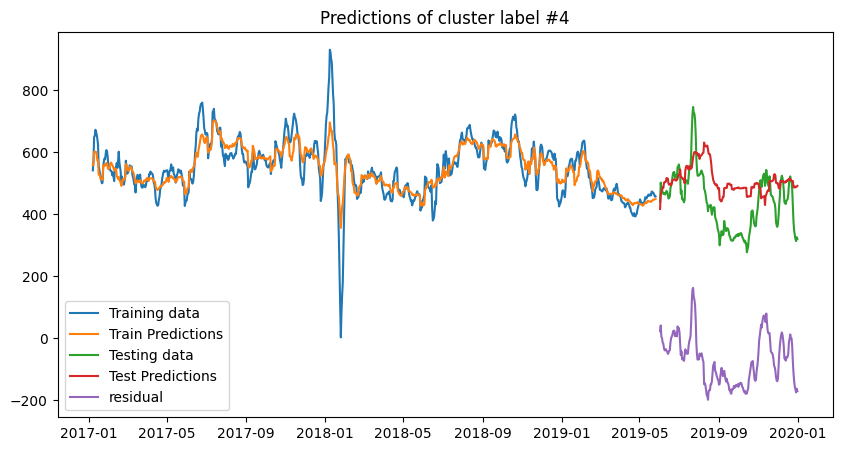

In [66]:
# lag=11
plt.title('Predictions of cluster label #4')
plt.plot(train_rf_4[['actual_data']].sort_index().rolling(7).mean(), label='Training data')
plt.plot(train_rf_4[['predictions']].sort_index().rolling(7).mean(), label='Train Predictions')
plt.plot(test_rf_4[['actual_data','predictions']].sort_index().rolling(7).mean(), label=['Testing data','Test Predictions'])
plt.plot(test_rf_4['residuals'].rolling(7).mean(), label = 'residual')
plt.legend();

In [67]:
new_plot=train_rf_4[train_rf_4.index.year == 2019]

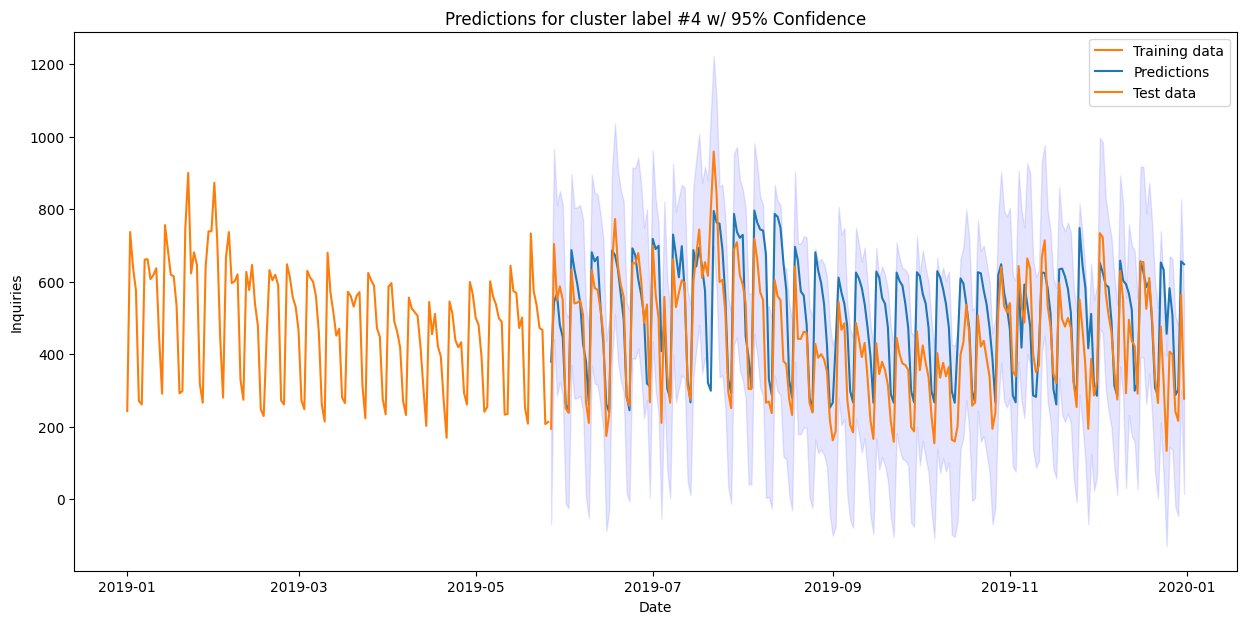

In [68]:
RMSFE = np.sqrt(sum([x**2 for x in test_rf_4['residuals'] ]) / len(test_rf_4['residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(new_plot.index, new_plot['actual_data'], color='#fc7d0b', label='Training data')
ax.plot(test_rf_4.index, test_rf_4['predictions'], label='Predictions')
ax.plot(test_rf_4.index, test_rf_4['actual_data'], label='Test data')
ax.fill_between(test_rf_4.index, (test_rf_4['actual_data']-band_size), (test_rf_4['actual_data']+band_size), color='b', alpha=.1)
ax.set_title("Predictions for cluster label #4 w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.legend()
plt.show()

Feature Importance

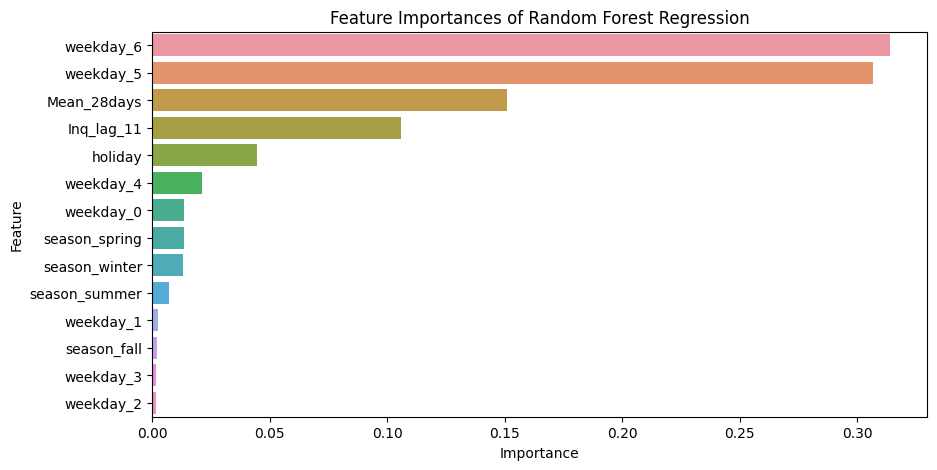

In [69]:
# Access the feature importances
importances = best_rfr_cluster4.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()


# 5th Top cluster --> cluster_label = 150

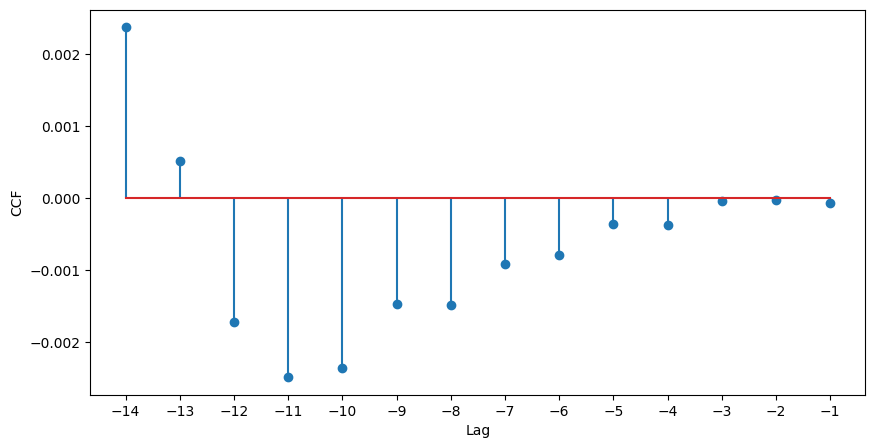

In [70]:
# Cross-correlation function (CCF)
data  = daily_top6clusters['_5_150']['inquiries_per_day']
lags = range(-14,0)  # lags to consider
ccf_vals  = ccf(data, data, unbiased=False, fft=True)

# Extract CCF values for specified lags
lag_vals = np.array(lags)
ccf_vals = ccf_vals[lag_vals + max(lags)]

# Create pandas dataframe to store results
result_df = pd.DataFrame({'lag': lag_vals, 'ccf': ccf_vals})

# Print results
#print(result_df)

# plot CCF
plt.stem(lag_vals, ccf_vals)
plt.xticks(lag_vals)
plt.xlabel('Lag')
plt.ylabel('CCF')
plt.show()

In [71]:
daily_clusters['_5_150'] = get_features(daily_top6clusters['_5_150'],11)

### Modeling with Lazy Predict

In [72]:
final_5_df  = daily_clusters['_5_150'].drop(columns=['weekday', 'index']).fillna(0)
final_5_df.columns

Index(['inquiries_per_day', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'holiday', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'Mean_28days',
       'Inq_lag_11'],
      dtype='object')

In [73]:
# assigning X and y
y = final_5_df['inquiries_per_day']
X = final_5_df.drop(columns=['inquiries_per_day'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the LazyRegressor object and fit the data
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the results DataFrame
print(models)

100%|██████████| 42/42 [00:23<00:00,  1.79it/s]

                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
LassoLars                                    0.38       0.42    437.04   
LassoLarsCV                                  0.38       0.42    437.15   
LarsCV                                       0.38       0.42    437.15   
LassoCV                                      0.38       0.42    437.29   
LassoLarsIC                                  0.37       0.42    438.42   
OrthogonalMatchingPursuitCV                  0.37       0.41    439.04   
OrthogonalMatchingPursuit                    0.37       0.41    440.26   
Lasso                                        0.37       0.41    441.07   
BayesianRidge                                0.37       0.41    441.07   
RidgeCV                                      0.37       0.41    441.30   
Ridge                                        0.37       0.41    441.58   
Lars                                  

### Hyperparameter Tuning with cross validation

Grid search on combined dataset

In [74]:
from sklearn.model_selection import TimeSeriesSplit

# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)
# Initialize models
grid_search_model = RandomForestRegressor(random_state=0)

# Set up the grid to pick hyperparameters from:
param_grid = {"n_estimators": [100, 500, 1000],
              "max_depth": [None],
              "min_samples_split": [2,3,5,7,8,10],
              "min_samples_leaf": [1,2,3],
              "bootstrap": [True]}

# Create the randomized search object
grid_search = GridSearchCV(grid_search_model, param_grid=param_grid , cv=tscv, 
                                   scoring="neg_mean_squared_error")

# Fit the model to the data
y = final_5_df['inquiries_per_day']
X = final_5_df.drop(columns=['inquiries_per_day'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = False, random_state = 0)


# Fit the randomized search on the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_grid_5 = grid_search.best_params_
print(best_params_grid_5)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}


Modeling with best parameters

In [75]:
# use the best hyperparameters to create the final Random Forest Regressor model
best_rfr_cluster5 = RandomForestRegressor(n_estimators=best_params_grid_5['n_estimators'],
                                  max_depth=best_params_grid_5['max_depth'],
                                  min_samples_split=best_params_grid_5['min_samples_split'],
                                  min_samples_leaf=best_params_grid_5['min_samples_leaf'],
                                  bootstrap=True,
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
best_rfr_cluster5.fit(X_train, y_train)

# use the final Random Forest Regressor model to make predictions on the train set
train_pred_5 = best_rfr_cluster5.predict(X_train).astype(int)

# calculate the mean squared error of the predictions
train_mae_5 = mean_absolute_error(y_train, train_pred_5)
train_rmse_5 = np.sqrt(mean_squared_error(y_train, train_pred_5))
print("Train MAE of Cluster #5: ", train_mae_5)
print('Train RMSE of Cluster #5:', train_rmse_5)

# use the final Random Forest Regressor model to make predictions on the test set
test_pred_5 = best_rfr_cluster5.predict(X_test).astype(int)

# calculate the mean squared error of the predictions
test_mae_5 = mean_absolute_error(y_test, test_pred_5)
# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse_5 = mean_squared_error(y_test, test_pred_5)
test_rmse_5 = np.sqrt(mean_squared_error(y_test, test_pred_5))
print("Test MAE of Cluster #5: ", test_mae_5)
print('Test RMSE of Cluster #5:', test_rmse_5)


# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance_5 = test_pred_5.var()
bias_5 = mse_5 - variance_5
print('Model: Random Forest Regressor')
print(f'Variance of Cluster #5: {variance_5}')
print(f'Bias of Cluster #5: {bias_5}')

Train MAE of Cluster #5:  167.56506849315068
Train RMSE of Cluster #5: 341.7521782957104
Test MAE of Cluster #5:  147.46118721461187
Test RMSE of Cluster #5: 264.67935283537247
Model: Random Forest Regressor
Variance of Cluster #5: 125081.61998290278
Bias of Cluster #5: -55026.46016555118


In [76]:
train_rf_5 = pd.DataFrame()
train_rf_5['actual_data'] = y_train
train_rf_5['predictions'] = train_pred_5
test_rf_5 = pd.DataFrame()
test_rf_5['actual_data'] = y_test
test_rf_5['predictions'] = test_pred_5
train_rf_5['residuals'] = train_rf_5['actual_data'] - train_rf_5['predictions']
test_rf_5['residuals'] = test_rf_5['actual_data'] - test_rf_5['predictions']

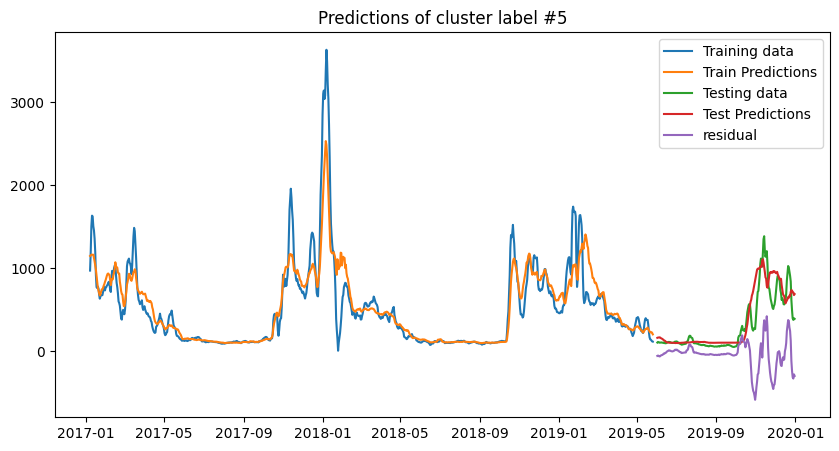

In [77]:
# lag=1
plt.title('Predictions of cluster label #5')
plt.plot(train_rf_5[['actual_data']].sort_index().rolling(7).mean(), label='Training data')
plt.plot(train_rf_5[['predictions']].sort_index().rolling(7).mean(), label='Train Predictions')
plt.plot(test_rf_5[['actual_data','predictions']].sort_index().rolling(7).mean(), label=['Testing data','Test Predictions'])
plt.plot(test_rf_5['residuals'].rolling(7).mean(), label = 'residual')
plt.legend();

In [78]:
new_plot=train_rf_5[train_rf_5.index.year == 2019]

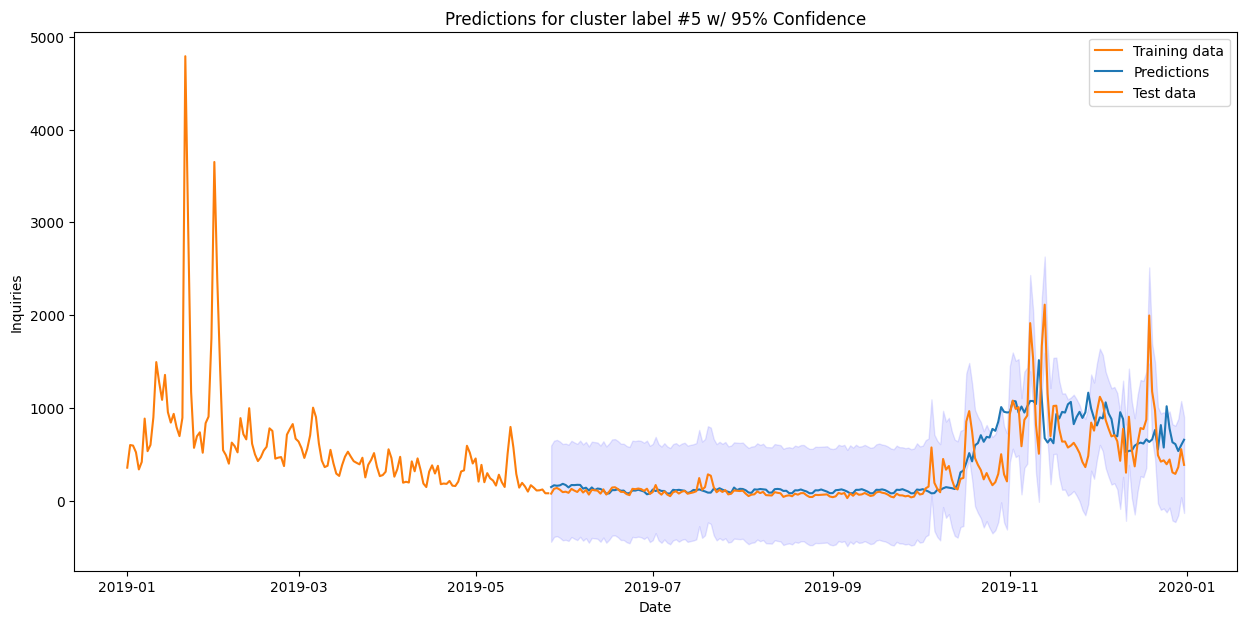

In [79]:
RMSFE = np.sqrt(sum([x**2 for x in test_rf_5['residuals'] ]) / len(test_rf_5['residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(new_plot.index, new_plot['actual_data'], color='#fc7d0b', label='Training data')
ax.plot(test_rf_5.index, test_rf_5['predictions'], label='Predictions')
ax.plot(test_rf_5.index, test_rf_5['actual_data'], label='Test data')
ax.fill_between(test_rf_5.index, (test_rf_5['actual_data']-band_size), (test_rf_5['actual_data']+band_size), color='b', alpha=.1)
ax.set_title("Predictions for cluster label #5 w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.legend()
plt.show()

Feature Importance

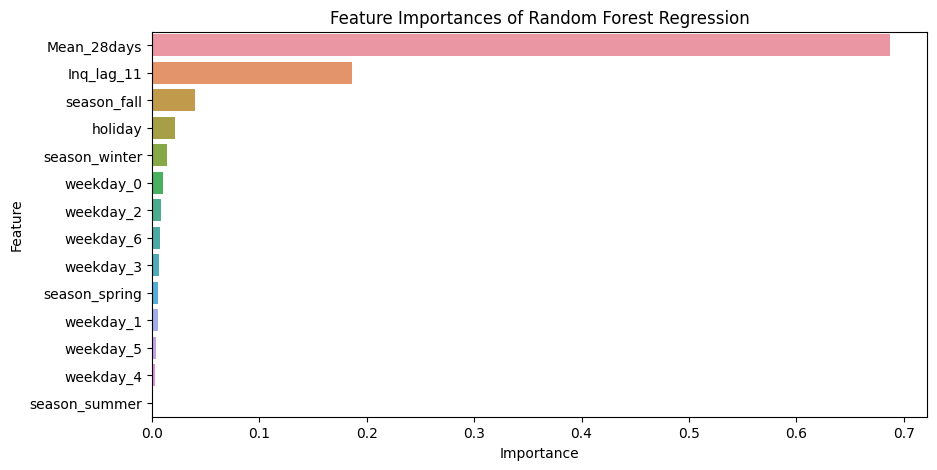

In [80]:
# Access the feature importances
importances = best_rfr_cluster5.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()


In [81]:
test_rf_5

,actual_data,predictions,residuals
date,,,
2019-05-27,75.00,146,-71.00
2019-05-28,127.00,165,-38.00
2019-05-29,136.00,160,-24.00
2019-05-30,118.00,164,-46.00
2019-05-31,91.00,181,-90.00
...,...,...,...
2019-12-27,304.00,629,-325.00
2019-12-28,288.00,609,-321.00
2019-12-29,360.00,534,-174.00


# 6 Top cluster --> cluster_label = 13

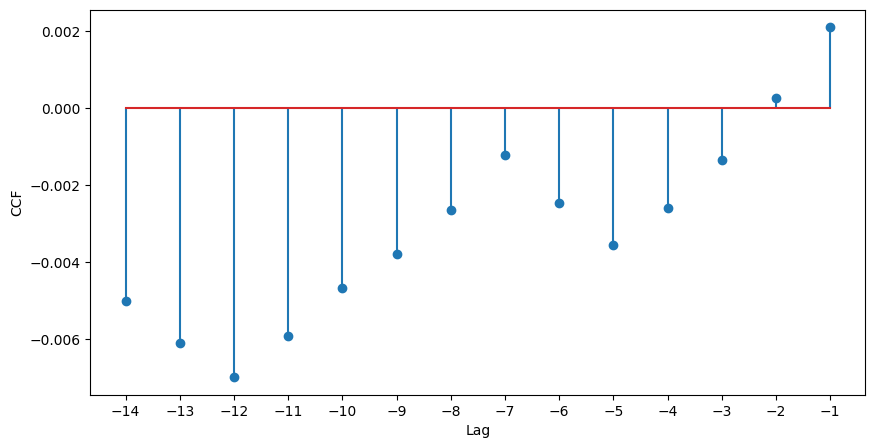

In [82]:
# Cross-correlation function (CCF)
data  = daily_top6clusters['_6_13']['inquiries_per_day']
lags = range(-14,0)  # lags to consider
ccf_vals  = ccf(data, data, unbiased=False, fft=True)

# Extract CCF values for specified lags
lag_vals = np.array(lags)
ccf_vals = ccf_vals[lag_vals + max(lags)]

# Create pandas dataframe to store results
result_df = pd.DataFrame({'lag': lag_vals, 'ccf': ccf_vals})

# Print results
#print(result_df)

# plot CCF
plt.stem(lag_vals, ccf_vals)
plt.xticks(lag_vals)
plt.xlabel('Lag')
plt.ylabel('CCF')
plt.show()

In [83]:
daily_clusters['_6_13'] = get_features(daily_top6clusters['_6_13'],12)
daily_clusters['_6_13']['Inq_lag_5'] = daily_clusters['_6_13']['inquiries_per_day'].shift(5).fillna(0)
daily_clusters['_6_13']['Inq_lag_1'] = daily_clusters['_6_13']['inquiries_per_day'].shift(1).fillna(0)
final_6_df  = daily_clusters['_6_13'].drop(columns=['weekday', 'index']).fillna(0)
final_6_df.columns

Index(['inquiries_per_day', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'holiday', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'Mean_28days',
       'Inq_lag_12', 'Inq_lag_5', 'Inq_lag_1'],
      dtype='object')

### Modeling with Lazy Predict

In [84]:
# assigning X and y
y = final_6_df['inquiries_per_day']
X = final_6_df.drop(columns=['inquiries_per_day'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the LazyRegressor object and fit the data
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the results DataFrame
print(models)

100%|██████████| 42/42 [00:31<00:00,  1.34it/s]

                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
RandomForestRegressor                        0.92       0.92  92.05   
ExtraTreesRegressor                          0.91       0.92  94.43   
HistGradientBoostingRegressor                0.91       0.92  95.85   
BaggingRegressor                             0.91       0.92  95.85   
LGBMRegressor                                0.91       0.92  96.80   
XGBRegressor                                 0.91       0.91  98.23   
GradientBoostingRegressor                    0.91       0.91  98.77   
DecisionTreeRegressor                        0.87       0.88 114.68   
KNeighborsRegressor                          0.85       0.86 125.27   
AdaBoostRegressor                            0.83       0.85 130.90   
ExtraTreeRegressor                           0.82       0.83 137.79   
LassoLarsIC                                  0.77       0.78 154.78   
Lars  

### Hyperparameter Tuning with cross validation

Grid search on combined dataset

In [85]:
# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)
# Initialize models
grid_search_model = RandomForestRegressor(random_state=0)

# Set up the grid to pick hyperparameters from:
param_grid = {"n_estimators": [100, 500, 1000],
              "max_depth": [None],
              "min_samples_split": [2,3,5,7,8,10],
              "min_samples_leaf": [1,2,3],
              "bootstrap": [True]}

# Create the randomized search object
grid_search = GridSearchCV(grid_search_model, param_grid=param_grid , cv=tscv, 
                                   scoring="neg_mean_squared_error")

# Fit the model to the data
y = final_6_df['inquiries_per_day']
X = final_6_df.drop(columns=['inquiries_per_day'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = False, random_state = 0)


# Fit the randomized search on the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_grid_6 = grid_search.best_params_
print(best_params_grid_6)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


Modeling with best parameters

In [86]:
# use the best hyperparameters to create the final Random Forest Regressor model
best_rfr_cluster6 = RandomForestRegressor(n_estimators=best_params_grid_6['n_estimators'],
                                  max_depth=best_params_grid_6['max_depth'],
                                  min_samples_split=best_params_grid_6['min_samples_split'],
                                  min_samples_leaf=best_params_grid_6['min_samples_leaf'],
                                  bootstrap=True,
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
best_rfr_cluster6.fit(X_train, y_train)

# use the final Random Forest Regressor model to make predictions on the train set
train_pred_6 = best_rfr_cluster6.predict(X_train).astype(int)

# calculate the mean squared error of the predictions
train_mae_6 = mean_absolute_error(y_train, train_pred_6)
train_rmse_6 = np.sqrt(mean_squared_error(y_train, train_pred_6))
print("Train MAE of Cluster #6: ", train_mae_6)
print('Train RMSE of Cluster #6:', train_rmse_6)

# use the final Random Forest Regressor model to make predictions on the test set
test_pred_6 = best_rfr_cluster6.predict(X_test).astype(int)

# calculate the mean squared error of the predictions
test_mae_6 = mean_absolute_error(y_test, test_pred_6)
# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse_6 = mean_squared_error(y_test, test_pred_6)
test_rmse_6 = np.sqrt(mean_squared_error(y_test, test_pred_6))
print("Test MAE of Cluster #6: ", test_mae_6)
print('Test RMSE of Cluster #6:', test_rmse_6)


# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance_6 = test_pred_6.var()
bias_6 = mse_6 - variance_6
print('Model: Random Forest Regressor')
print(f'Variance of Cluster #6: {variance_6}')
print(f'Bias of Cluster #6: {bias_6}')

Train MAE of Cluster #6:  35.199771689497716
Train RMSE of Cluster #6: 61.71224096507521
Test MAE of Cluster #6:  183.64840182648402
Test RMSE of Cluster #6: 215.77464779286973
Model: Random Forest Regressor
Variance of Cluster #6: 27375.76460040449
Bias of Cluster #6: 19182.934029732492


In [87]:
train_rf_6 = pd.DataFrame()
train_rf_6['actual_data'] = y_train
train_rf_6['predictions'] = train_pred_6
test_rf_6 = pd.DataFrame()
test_rf_6['actual_data'] = y_test
test_rf_6['predictions'] = test_pred_6
train_rf_6['residuals'] = train_rf_6['actual_data'] - train_rf_6['predictions']
test_rf_6['residuals'] = test_rf_6['actual_data'] - test_rf_6['predictions']

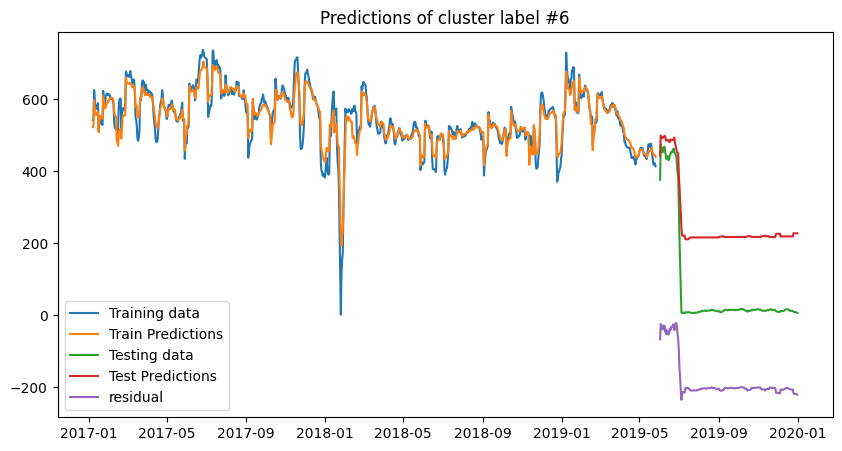

In [88]:
#lag=12 & 5 & 1
plt.title('Predictions of cluster label #6')
plt.plot(train_rf_6[['actual_data']].sort_index().rolling(7).mean(), label='Training data')
plt.plot(train_rf_6[['predictions']].sort_index().rolling(7).mean(), label='Train Predictions')
plt.plot(test_rf_6[['actual_data','predictions']].sort_index().rolling(7).mean(), label=['Testing data','Test Predictions'])
plt.plot(test_rf_6['residuals'].rolling(7).mean(), label = 'residual')
plt.legend();

In [89]:
new_plot=train_rf_6[train_rf_6.index.year == 2019]

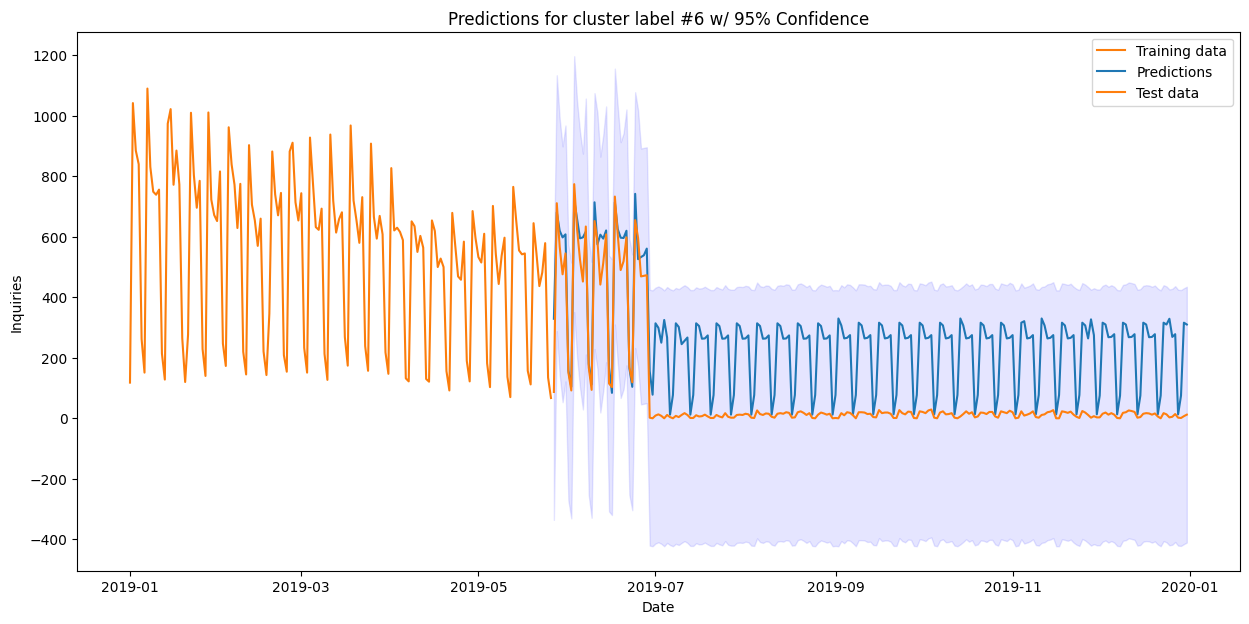

In [90]:
RMSFE = np.sqrt(sum([x**2 for x in test_rf_6['residuals'] ]) / len(test_rf_6['residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(new_plot.index, new_plot['actual_data'], color='#fc7d0b', label='Training data')
ax.plot(test_rf_6.index, test_rf_6['predictions'], label='Predictions')
ax.plot(test_rf_6.index, test_rf_6['actual_data'], label='Test data')
ax.fill_between(test_rf_6.index, (test_rf_6['actual_data']-band_size), (test_rf_6['actual_data']+band_size), color='b', alpha=.1)
ax.set_title("Predictions for cluster label #6 w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.legend()
plt.show()

Feature Importance

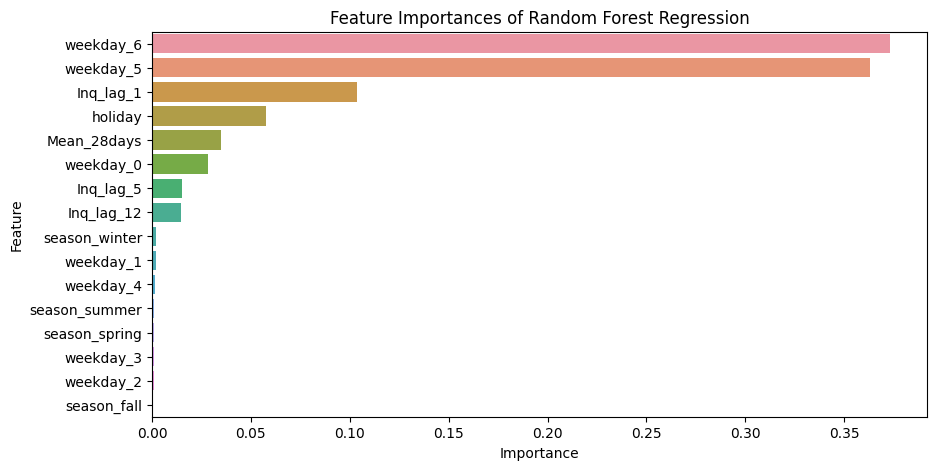

In [91]:
# Access the feature importances
importances = best_rfr_cluster6.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()


# Combining predictions

In [92]:
train_combined_clusters = pd.DataFrame()
train_combined_clusters['predictions'] = train_rf_1['predictions']+ train_rf_2['predictions']+train_rf_3['predictions']+train_rf_4['predictions']+train_rf_5['predictions']+train_rf_6['predictions']
test_combined_clusters = pd.DataFrame()
test_combined_clusters['predictions'] = test_rf_1['predictions']+ test_rf_2['predictions']+test_rf_3['predictions']+test_rf_4['predictions']+test_rf_5['predictions']+test_rf_6['predictions']

In [93]:
train_data = pd.DataFrame()
train_data['actual_data'] = train_rf['train']
train_data['WholeData_Predictions'] = train_rf['train_pred']
train_data['Combined_Predictions'] = train_combined_clusters['predictions']

test_data = pd.DataFrame()
test_data['actual_data'] = predictions_rf['test']
test_data['WholeData_Predictions'] = predictions_rf['test_pred']
test_data['Combined_Predictions'] = test_combined_clusters['predictions']

In [94]:
train_mae_combined = mean_absolute_error(train_data['actual_data'], train_data['Combined_Predictions'] )
train_rmse_combined = np.sqrt(mean_squared_error(train_data['actual_data'], train_data['Combined_Predictions'] ))
train_mse_combined = mean_squared_error(train_data['actual_data'], train_data['Combined_Predictions'] )

print("Train MAE of Cluster combined: ", train_mae_combined)
print('Train RMSE of Cluster combined:', train_rmse_combined)


test_mae_combined = mean_absolute_error(test_data['actual_data'], test_data['Combined_Predictions'] )
test_rmse_combined = np.sqrt(mean_squared_error(test_data['actual_data'], test_data['Combined_Predictions'] ))
test_mse_combined = mean_squared_error(test_data['actual_data'], test_data['Combined_Predictions'] )

print("Test MAE of Cluster combined: ", test_mae_combined)
print('Test RMSE of Cluster combined:', test_rmse_combined)


# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance_combined = test_data['Combined_Predictions'].var()
bias_combined = test_mse_combined - variance_combined
print('Model: Random Forest Regressor')
print(f'Variance of Cluster combined: {variance_combined}')
print(f'Bias of Cluster combined: {bias_combined}')

Train MAE of Cluster combined:  284.7659817351598
Train RMSE of Cluster combined: 553.2395698876733
Test MAE of Cluster combined:  595.9634703196347
Test RMSE of Cluster combined: 683.8269961990339
Model: Random Forest Regressor
Variance of Cluster combined: 137073.08663231533
Bias of Cluster combined: 330546.27409827826


In [95]:
print("Train MAE of Whole: ", train_mae)
print('Train RMSE of Whole:', train_rmse)
print("Test MAE of Whole: ", test_mae)
print('Test RMSE of Whole:', test_rmse)
print('Model: Random Forest Regressor')
print(f'Variance of Whole: {variance}')
print(f'Bias of Whole: {bias}')

Train MAE of Whole:  334.7751141552511
Train RMSE of Whole: 640.1509141775667
Test MAE of Whole:  1127.2191780821918
Test RMSE of Whole: 1253.99064360408
Model: Random Forest Regressor
Variance of Whole: 129501.59783991158
Bias of Whole: 1442990.9364066636


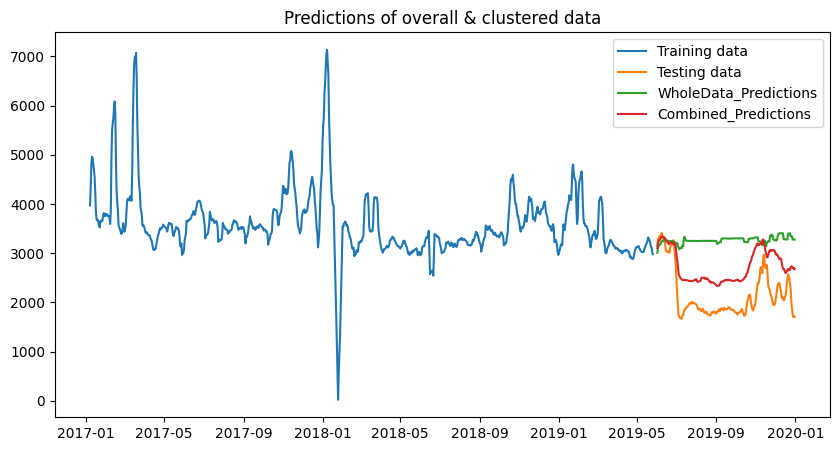

In [96]:
plt.title('Predictions of overall & clustered data')
plt.plot(train_data['actual_data'].rolling(7).mean(),label='Training data')
plt.plot(test_data.rolling(7).mean(),label=['Testing data','WholeData_Predictions','Combined_Predictions'])
plt.legend()

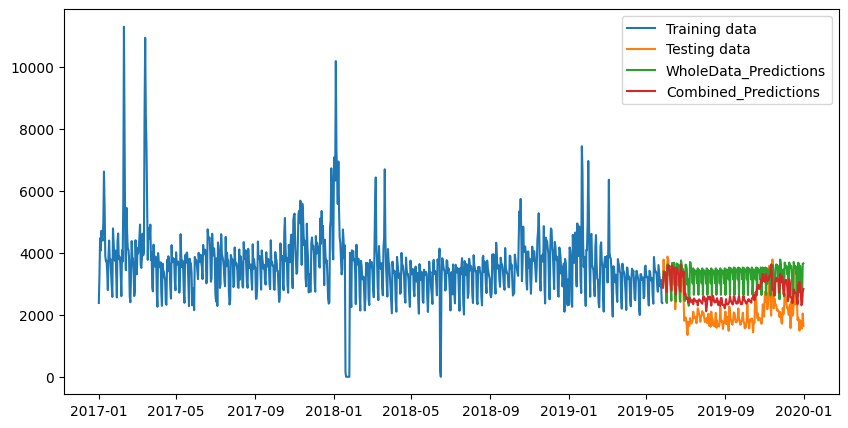

In [97]:
plt.plot(train_data['actual_data'],label='Training data')
plt.plot(test_data,label=['Testing data','WholeData_Predictions','Combined_Predictions'])
plt.legend()

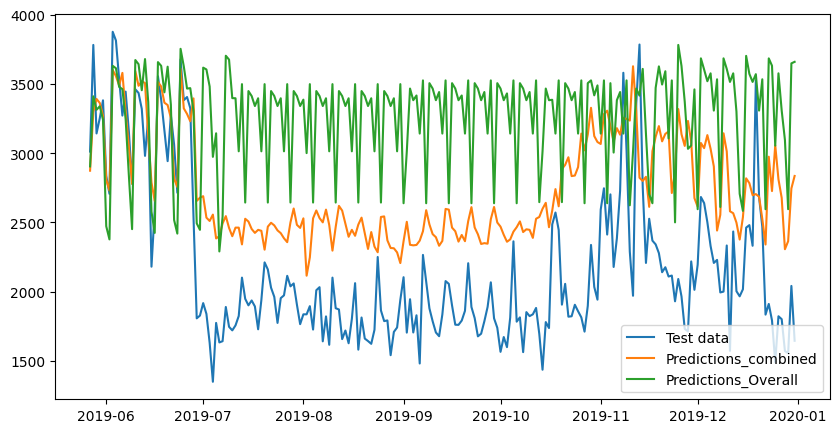

In [98]:
plt.plot(predictions_rf['test'].fillna(0),label='Test data')
plt.plot(test_combined_clusters['predictions'].fillna(0),label='Predictions_combined')
plt.plot(predictions_rf['test_pred'].fillna(0),label='Predictions_Overall')
plt.legend();

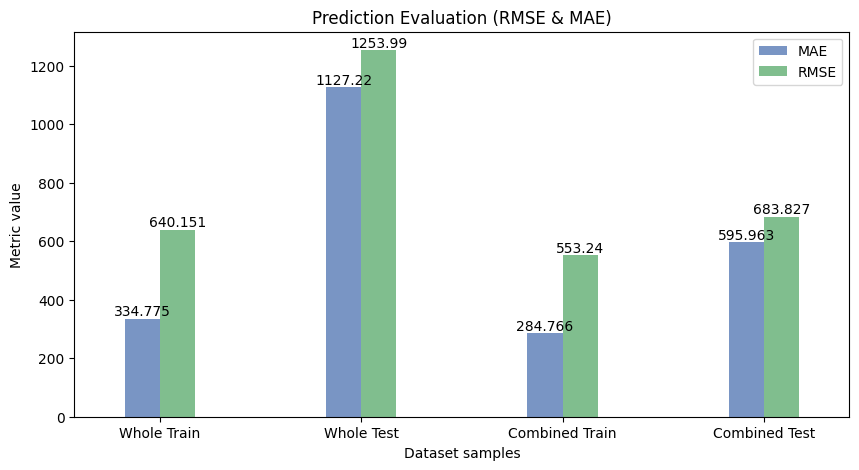

In [99]:
#sns.set_style("dark")
matplotlib.style.use('seaborn-deep') 
plotdata = pd.DataFrame({
    "MAE":[train_mae, test_mae, train_mae_combined, test_mae_combined],
    "RMSE":[train_rmse, test_rmse, train_rmse_combined, test_rmse_combined]
    }, 
    index=["Whole Train", "Whole Test", "Combined Train", "Combined Test"]
)

for i, v in enumerate(plotdata["RMSE"]):
    ax.text(v + 3, i + .25, str(v),
            color = 'blue', fontweight = 'bold')

ax=plotdata.plot(kind="bar",width=0.35,alpha=0.75, rot=0)
plt.title("Prediction Evaluation (RMSE & MAE)")
plt.xlabel("Dataset samples")
plt.ylabel("Metric value")

for container in ax.containers:
    ax.bar_label(container)

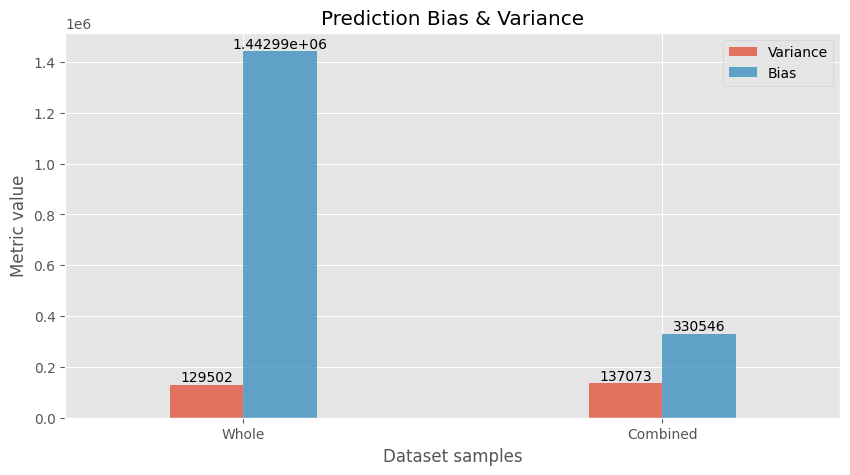

In [100]:
matplotlib.style.use('ggplot') 
plotdata = pd.DataFrame({
    "Variance":[variance, variance_combined],
    "Bias":[bias, bias_combined]
    }, 
    index=["Whole", "Combined"]
)
for i, v in enumerate(plotdata["Bias"]):
    ax.text(v + 3, i + .25, str(v),
            color = 'blue', fontweight = 'bold')

ax=plotdata.plot(kind="bar",width=0.35,alpha=0.75, rot=0)
plt.title("Prediction Bias & Variance")
plt.xlabel("Dataset samples")
plt.ylabel("Metric value")
for container in ax.containers:
    ax.bar_label(container)